# BFS Capstone Project

## Bank Marketing

CredX is a leading credit card provider that gets thousands of credit card applications every year. But in the past few years, it has experienced an increase in credit loss. The CEO believes that the best strategy to mitigate credit risk is to ‘acquire the right customers’.

In this project, your task is to help CredX identify the right customers using predictive models. Using past data of the bank’s applicants, you need to determine the factors affecting credit risk, create strategies to mitigate the acquisition risk and assess the financial benefit of your project.  

### Steps Performed

- [**Part1** - Importing Libraries & Creating UDF ](#0.0) :-      
    - 1.[Impoting Libraries](#0.1)       
    - 2.[Creating User Defined Functions](#0.2)  
    
    
 - [**Part2** - Building Model on Demographic Data ](#1) :-      
    - 1.[Data Importing & Data Understanding](#1.1)           
    - 2.[Data Cleaning](#1.2)       
    - 3.[Exploratory Data Analysis](#1.3)    
    - 4.[Model Buiding on Non WOE Dataset](#1.4)
      - a.[Data Preparation](#1.41)       
      - b.[Test Train Split](#1.42)    
      - c.[Standardization](#1.43)           
      - d.[Model Building](#1.44)       
    - 5.[Model Buiding on Woe Dataset](#1.5)
      - a.[Calculate WOE & IV](#1.51)       
      - b.[Create WOE Dataframe](#1.52)       
      - c.[Test Train Split](#1.53)    
      - d.[Model Building](#1.54)   
      

 - [**Part3** - Building Model on Demographic Data + Credit Data ](#2) :-      
    - 1.[Data Importing & Data Understanding](#2.1)           
    - 2.[Data Cleaning](#2.2)       
    - 3.[Exploratory Data Analysis](#2.3)    
    - 4.[Model Buiding on Non WOE Dataset](#2.4)
      - a.[Data Preparation](#2.41)       
      - b.[Test Train Split](#2.42)    
      - c.[Standardization](#2.43)           
      - d.[Model Building](#2.44)       
    - 5.[Model Buiding on Woe Dataset](#2.5)
      - a.[Calculate WOE & IV](#2.51)       
      - b.[Create WOE Dataframe](#2.52)       
      - c.[Test Train Split](#2.53)    
      - d.[Model Building](#2.54)     
    
 
  - [**Part4** -Model Selection & Model Evaluation](#3) :-      
    - 1.[Selection of Best Model](#3.1)           
    - 2.[Model Evaluation](#3.2) 
    - 3.[Application Scorecard](#3.3) 
    - 4.[Assessing the financial benefit of Model](#3.4) 

##  Part 1 :- `Importing Libraries & Creating UDF`<a id="0.0"></a>

#### i. Import Required Libraries<a id="0.1"></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import NumPy and Pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# Import library for test-train split  & Scaling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [4]:
# Importing Library for Model Building  
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import StratifiedKFold,GridSearchCV,KFold,cross_val_score

In [5]:
#Random Forest & Decision Tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from sklearn.tree import export_graphviz

In [6]:
# Importing  metrics from sklearn library
from sklearn.metrics import confusion_matrix,classification_report,precision_recall_fscore_support
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score
from imblearn.metrics import sensitivity_specificity_support

##### ii. Create required Functions <a id="0.2"></a>

In [7]:
#Check univariante Analysis of column in dataframe
def univariante_analysis(df_name,column):
    #Check response rate per category  
    count_prospects = df_name.groupby(column)['Performance Tag'].sum().reset_index(name = 'count_defaulters')
    No_of_prospect = df_name.groupby(column)['Performance Tag'].count().reset_index(name = 'No_of_Applicants')
    agg_df = count_prospects.merge(No_of_prospect, on = column.name)
    agg_df['Default_Rate'] = 100*(agg_df['count_defaulters']/agg_df['No_of_Applicants']).round(4)
    print(agg_df)

    #Create barplot per category
    ax = sns.barplot(x=column.name, y='Default_Rate', data=agg_df)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
    plt.show()

In [8]:
#Function to display the logistic regression model
def get_GLM(y_train, X_train):
    X_train = sm.add_constant(X_train)
    return X_train, sm.GLM(y_train, X_train, family = sm.families.Binomial()).fit()

def get_model_and_print_summary(X_df):
    X_train, lm = get_GLM(list(y_train), X_df)
    print(lm.summary())
    P_values_df=pd.DataFrame({'Pvalues':lm.pvalues.sort_values(ascending=False)})
    P_values_df.reset_index(inplace=True)
    P_values_df['Variables']=P_values_df.iloc[:,0]
    #print('\n\n**Model Analysis**')
    print('\n\nThe feature with highest Pvalues is :-', P_values_df.Variables[0])
    print('The with P-value of Feature is:- ', P_values_df.Pvalues[0])
    if (P_values_df.Pvalues[0] >0.05):
        print('\n\nLets Drop variable ',P_values_df.Variables[0],' as it highest P-value and build the model again')
    else :
        print('\n\nThe P value of all variables is less than 0.05 .Hence Lets check VIF values of variables')
    return X_train, lm ,P_values_df.Variables[0]

In [9]:
#Function to display the VIF
def get_vif(X_df):
    vif = pd.DataFrame()
    vif['Features'] = X_df.columns
    vif['VIF'] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    print(vif)

In [10]:
#Function to draw ROC curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs,drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    return None

#Function to draw Accuracy Sensitivity Specificty Graph
def accuracy_sensitivity_specificty_graph(cutoff_df_name,optimum_cutoff_value):
    plt.figure(figsize=(16, 6))
    sns.lineplot(data=cutoff_df_name)
    plt.title('Accuracy vs Sensitivity vs Specificity for various probabilities', fontsize=18)
    plt.axvline(optimum_cutoff_value, color='r', linestyle='-.')
    
#Function to draw Accuracy Precision Graph
def accuracy_precision_graph(cutoff_df_name,optimum_cutoff_value):
    plt.figure(figsize=(16, 6))
    sns.lineplot(data=cutoff_df_name)
    plt.title('Precision vs Recall for various probabilities', fontsize=18)
    plt.axvline(optimum_cutoff_value, color='b', linestyle='-.')

In [11]:
def create_cutoff_df(y_train_pred_final_df_name):
    cutoff_df = pd.DataFrame(columns=['Accuracy', 'Sensitivity','Specificity'])
    for i in numbers:
        confusion = confusion_matrix(y_train_pred_final_df_name.predicted_response, y_train_pred_final_df_name[i] )
        total=sum(sum(confusion))
        accuracy = (confusion[0,0]+confusion[1,1])/total
        specificity = confusion[0,0]/(confusion[0,0]+confusion[0,1])
        sensitivity = confusion[1,1]/(confusion[1,0]+confusion[1,1])
        cutoff_df.loc[i] =[accuracy, sensitivity, specificity]
    return cutoff_df

In [12]:
#Function to calculate metrics like sensitivity, specificity etc
def metrics_dataframe(actual, predicted):
    confusion = confusion_matrix(actual, predicted)
    print('Confusion Matrix is :-')
    print(confusion)
    
    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives

    specificity = TN/float(TN+FP)
    accuracy = accuracy_score(actual, predicted)
    precision = TP/float(TP+FP)
    recall = TP/float(TP+FN)
    false_positive_rate = FP/float(TN+FP)
    positive_predictive_value = TP/float(TP+FP)
    negative_predictive_value = TN/float(TN+ FN)
    
    print('Metrics and their score for above confusion metris :-')
    return_data = {'Metric': ['Sensitivity/Recall', 'Specificity', 'Accuracy', 'Precision', 'False Positive Rate',
                             'Positive Predictive Value', 'Negative Predictive Value'],
                   'Score': [ recall,specificity, accuracy, precision, false_positive_rate, positive_predictive_value,
                            negative_predictive_value]}
    return pd.DataFrame.from_dict(return_data)

In [13]:
## creating functions for woe and IV
def calculate_WOE_IV(data, target, bins=8, show_woe=False):
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    #Extract Column Names
    cols = data.columns
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        null_data = data[data[ivars].isnull()]
        nonnull_data = data[data[ivars].notnull()]
        
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>8):            
            binned_x = pd.qcut(nonnull_data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': nonnull_data[target]})
        else:
            d0 = pd.DataFrame({'x': nonnull_data[ivars], 'y': nonnull_data[target]})
            
        if(~null_data.empty):
            d1 = pd.DataFrame({'x' : 'NULL', 'y' : null_data[target]})
            d0 = pd.concat([d0, d1], axis = 0)
            
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'Number', 'Defaults']                
        d['Defaults(%)'] = np.maximum(d['Defaults'], 0.5) / d['Defaults'].sum()
        d['Non-Defaults'] = d['Number'] - d['Defaults']
        d['Non-Defaults(%)'] = np.maximum(d['Non-Defaults'], 0.5) / d['Non-Defaults'].sum()
        d['WOE'] = np.log(d['Defaults(%)']/d['Non-Defaults(%)'])
        d['IV'] = round(d['WOE'] * (d['Defaults(%)'] - d['Non-Defaults(%)']),6)
        d.insert(loc=0, column='Variable', value=ivars)
        print("\n\nInformation value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        woeDF['min_val']=0
        woeDF['max_val']=0
        for cols in np.unique(woeDF.Variable):
            if (data[cols].dtype.kind in 'bifc') and (len(np.unique(data[cols]))>8):
                woeDF.loc[(woeDF.Variable==cols) & (woeDF.Cutoff!='NULL'),'min_val'
                         ] = woeDF[woeDF.Variable==cols
                                  ]['Cutoff'].apply(lambda x: 0 if x=='NULL' else float(str(x).split(',')[0].split('(')[1].strip()))
                woeDF.loc[(woeDF.Variable==cols) & (woeDF.Cutoff!='NULL'),'max_val'
                         ] = woeDF[woeDF.Variable==cols
                                  ]['Cutoff'].apply(lambda x: 0 if x=='NULL' else float(str(x).split(',')[1].split(']')[0].strip()))


        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [14]:
## function to create woe transformed dataframe from original dataframe
def create_woe_dataframe(no_impute_df,woe_df) :
    woe_data = pd.DataFrame(no_impute_df).copy()

    for cols in woe_data.columns:
        df = woe_df[woe_df.Variable==cols]
        if (woe_data[cols].dtype.kind in 'bifc') and (len(np.unique(woe_data[cols]))>8):
            for idx in df.index :
                minval = df[idx:idx+1].min_val.sum()
                maxval = df[idx:idx+1].max_val.sum()
                woe_data.loc[(woe_data[cols]>minval) & (woe_data[cols]<=maxval),cols] = df[idx:idx+1].WOE.sum()
        else:
            for idx in df.index :
                cutoff = list(df[idx:idx+1].Cutoff)[0]
                woe_data.loc[woe_data[cols]==cutoff,cols] = df[idx:idx+1].WOE.sum()

        woe_data.loc[pd.isnull(woe_data[cols]),cols] = df[df.Cutoff=='NULL'].WOE.sum()
        woe_data[cols] = pd.to_numeric(woe_data[cols])
    
    return woe_data

In [15]:
# Create dataframe having actual , predicted and prob predicted response
def create_response_dataframe(cutoff_value):
    response_df=pd.DataFrame()
    
    response_df['actual_response'] = pd.concat([y_train,y_test])

    y_pred_prob_train = pd.DataFrame(lm_final.predict(X_train_final), columns = ['probablity_predicted_response']) 
    y_pred_prob_test = pd.DataFrame(lm_final.predict(sm.add_constant(X_test)[X_train_final.columns]), columns = ['probablity_predicted_response'])
    response_df['probablity_predicted_response'] = pd.concat([y_pred_prob_train,y_pred_prob_test])

    response_df['predicted_response'] = response_df.probablity_predicted_response.map( lambda x: 1 if x > cutoff_value else 0)

    response_df.sort_values(by=['probablity_predicted_response'],ascending=False,inplace=True)
    return response_df

#Generate Lift Dataframe
def generate_lift_dataframe(df) :
    df['decile'] = pd.qcut(df['probablity_predicted_response'], 10, labels=np.arange(10, 0, -1))
    lift_df = df.groupby('decile')['probablity_predicted_response'].count().reset_index()
    lift_df.rename({'probablity_predicted_response':'total'}, axis=1, inplace=True)
    lift_df_pred = df[df['actual_response']==1].groupby('decile')['actual_response'].count().reset_index()
    lift_df_final = lift_df.merge(lift_df_pred,on = 'decile')
    lift_df_final = lift_df_final.sort_values(['decile'], ascending=False)
    lift_df_final['cumresp'] = lift_df_final['actual_response'].cumsum()
    lift_df_final['gain'] = 100*(lift_df_final['cumresp']/sum(lift_df_final['actual_response']))
    lift_df_final['cumlift'] = lift_df_final['gain']/(lift_df_final['decile'].astype('int')*(100/10))
    return lift_df_final

##  Part 2 :- `Building Model on Demographic Data`<a id="1"></a>

### Step 1 :- Data Importing & Data Understanding <a id="1.1"></a>

##### A. Importing Csv File

In [16]:
Demographic = pd.read_csv("Demographic data.csv", sep=",")
Demographic.head()

,Application ID,Age,Gender,Marital Status (at the time of application),No of dependents,Income,Education,Profession,Type of residence,No of months in current residence,No of months in current company,Performance Tag
0,954457215,48,F,Married,2.0,40.0,Bachelor,SAL,Rented,113,56,0.0
1,432830445,31,M,Married,4.0,55.0,Professional,SE_PROF,Rented,112,46,0.0
2,941387308,32,M,Single,2.0,46.0,Bachelor,SE_PROF,Rented,104,49,0.0
3,392161677,43,M,Married,1.0,53.0,Bachelor,SE,Rented,94,53,0.0
4,182011211,35,F,Married,5.0,44.0,Professional,SAL,Rented,112,43,0.0


In [17]:
Demographic = Demographic.rename(columns = {"Marital Status (at the time of application)": "Marital Status",
                                            "Profession ":"Profession",
                                           "No of months in current company": "Months_Current_Company",
                                           "No of months in current residence": "Months_Current_Residence"})

In [18]:
#Creating copy of Demographic Dataframe for further analysis
Demographic_copy=pd.DataFrame(Demographic).copy()

##### B. Inspect the various aspects of the  dataframe

In [19]:
Demographic.shape

(71295, 12)

In [20]:
## describing demographic data
Demographic.describe()

,Application ID,Age,No of dependents,Income,Months_Current_Residence,Months_Current_Company,Performance Tag
count,7.129500e+04,71295.000000,71292.000000,71295.000000,71295.000000,71295.000000,69870.000000
mean,4.989601e+08,44.943039,2.865188,27.195224,34.563420,33.958244,0.042193
std,2.885905e+08,9.939211,1.382319,15.514626,36.759758,20.410824,0.201030
min,1.004500e+05,-3.000000,1.000000,-0.500000,6.000000,3.000000,0.000000
25%,2.483719e+08,37.000000,2.000000,14.000000,6.000000,16.000000,0.000000
50%,4.975698e+08,45.000000,3.000000,27.000000,11.000000,34.000000,0.000000
75%,7.495868e+08,53.000000,4.000000,40.000000,60.000000,51.000000,0.000000
max,1.000084e+09,65.000000,5.000000,60.000000,126.000000,133.000000,1.000000


In [21]:
# Looking at all the column names
Demographic.columns

Index(['Application ID', 'Age', 'Gender', 'Marital Status', 'No of dependents',
       'Income', 'Education', 'Profession', 'Type of residence',
       'Months_Current_Residence', 'Months_Current_Company',
       'Performance Tag'],
      dtype='object')

### Step 2 :-  Data Cleaning<a id="1.2"></a>

##### i.Remove Duplicate Rows

In [22]:
#Check number of records before dropping duplicate records
print('Total Number of Records before dropping duplicate records:- ',Demographic['Application ID'].count())

#drop Records having duplicate values
Demographic = Demographic.drop_duplicates(['Application ID'])

#Check number of records after dropping duplicate records
print('Total Number of Records after dropping duplicate records:- ',Demographic['Application ID'].nunique())

Total Number of Records before dropping duplicate records:-  71295
Total Number of Records after dropping duplicate records:-  71292


There were 3 duplicate records which have beend removed

##### ii. Check Column wise Missing values

In [23]:
#Let us check the null values
Demographic.isnull().sum(axis=0).sort_values(ascending=False)

Performance Tag             1425
Education                    119
Profession                    14
Type of residence              8
Marital Status                 6
No of dependents               3
Gender                         2
Months_Current_Company         0
Months_Current_Residence       0
Income                         0
Age                            0
Application ID                 0
dtype: int64

In [24]:
# Records having missing value of Performance Tag are of no value as this is the depedent variable.Hence droppping the variable 
Demographic.dropna(subset=['Performance Tag'],inplace=True)

In [25]:
# Number of Records having missing value of  in columns like Education, Profession Type of Residence, Marital Status,No of dependents & Gender is very small compared to total number of Records
# Hence lets drop these records also
Demographic.dropna(subset=['Education','Profession','Type of residence','Marital Status','No of dependents','Gender'],inplace=True)

In [26]:
#Lets Check if there are any column with null value
Demographic.isnull().sum(axis=0).sort_values(ascending=False) 

Performance Tag             0
Months_Current_Company      0
Months_Current_Residence    0
Type of residence           0
Profession                  0
Education                   0
Income                      0
No of dependents            0
Marital Status              0
Gender                      0
Age                         0
Application ID              0
dtype: int64

In [27]:
#Lets Check number of records left after data cleaning process
Demographic.shape

(69718, 12)

Percentage of Records left after Data Cleaning = 69718/71295 =97.78%     
Due to Data Cleaning around 2.2% data is lost which is not much significant           
Lets Proceed Futher with Data Exploration 

### Step 3 :-  Exploratory Data Analysis<a id="1.3"></a>

Now, we will do Exploratory Data Analysis on individual features and look for patterns.

1. [Univariante Analysis](#1.3A)   
    - [Age](#1.3a) : Age of customer
    - [Gender](#1.3b) : Gender of customer
    - [Marital Status](#1.3c) : Marital status of customer (at the time of application)
    - [No of dependents](#1.3d) :	No. of childrens of customers
    - [Income](#1.3e) :	Income of customers
    - [Education](#1.3f)	: Education of customers
    - [Profession](#1.3g) : Profession of customers
    - [Type of residence](#1.3h)	:Type of residence of customers
    - [No of months in current residence](#1.3i)	: No of months in current residence of customers
    - [No of months in current company](#1.3j) :	No of months in current company of customers



2. [Multivariante Analysis](#1.3B)
    - [Heatmap](#1.3k)

### 1. Univariante Analysis<a id="3A"></a>

#### a. Age<a id="1.3a"></a>

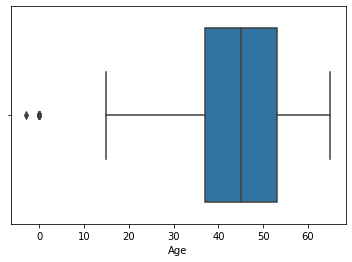

In [28]:
sns.boxplot(x='Age', data=Demographic)
plt.show()

In [29]:
# Since there are a fair few data entries with age < 18, we will club all of those ages at 18 
# we can assume that the behaviour will not change significantly with age at age below 18

Demographic['Age'][Demographic['Age']<18] =18

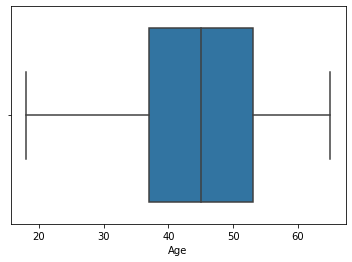

In [30]:
sns.boxplot(x='Age', data=Demographic)
plt.show()

In [31]:
# To understand the behaviour of people with age, we are going to bucket the age groups into brackets of 10 and 
# study the response rates

bins = np.arange(10,Demographic['Age'].max() + 10, 10)
Demographic['age_bins'] = pd.cut(Demographic['Age'], bins, include_lowest=True)

        age_bins  count_defaulters  No_of_Applicants  Default_Rate
0  (9.999, 20.0]               3.0               137          2.19
1   (20.0, 30.0]             238.0              5786          4.11
2   (30.0, 40.0]             828.0             18642          4.44
3   (40.0, 50.0]             956.0             22823          4.19
4   (50.0, 60.0]             717.0             17506          4.10
5   (60.0, 70.0]             200.0              4824          4.15


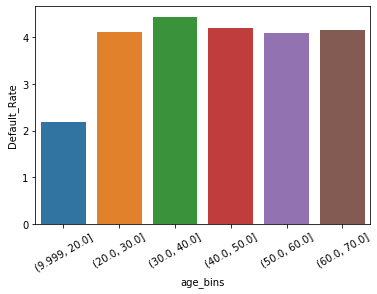

In [32]:
univariante_analysis(Demographic,Demographic['age_bins'])

###### Analysis of Impact of Age :-  
 - People in age group 10-20 have lowest default rate but number of records in that age group is very low
 - Default rate of People in age group 30 - 40 is highest however the difference is not signigicantly high. 

There does not seem to be significant relation between default rate and Age of Applicant

#### b. Gender<a id="1.3b"></a>

In [33]:
Demographic['Gender'].value_counts()

M    53239
F    16479
Name: Gender, dtype: int64

  Gender  count_defaulters  No_of_Applicants  Default_Rate
0      F             717.0             16479          4.35
1      M            2225.0             53239          4.18


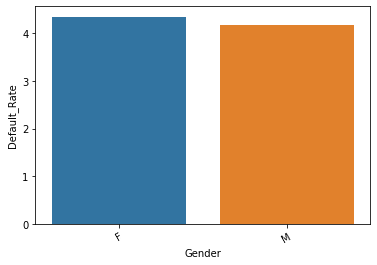

In [34]:
univariante_analysis(Demographic,Demographic['Gender'])

###### Analysis of Impact of Gender :-  
 - Default Rate of Female is higher than man but the difference is not signigicantly high. 

Thus, there does not seem to be significant relation between default rate and Gender of Applicant

##### c.Marital<a id="1.3c"></a>

In [35]:
Demographic['Marital Status'].value_counts()

Married    59423
Single     10295
Name: Marital Status, dtype: int64

  Marital Status  count_defaulters  No_of_Applicants  Default_Rate
0        Married            2497.0             59423          4.20
1         Single             445.0             10295          4.32


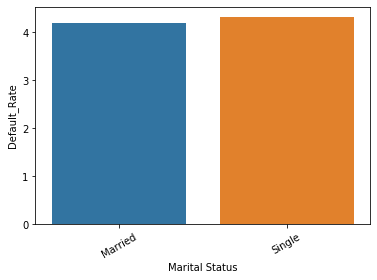

In [36]:
univariante_analysis(Demographic,Demographic['Marital Status'])

###### Analysis of Impact of Marital Status:-  
 - Default Rate of Single person is slightly higher than married person but the difference is not signigicantly high. 

Thus, there does not seem to be significant relation between default rate and Marital Status of Applicant

##### d.No of dependents<a id="1.3d"></a>

In [37]:
Demographic['No of dependents'].value_counts()

3.0    15608
1.0    15181
2.0    15103
4.0    11974
5.0    11852
Name: No of dependents, dtype: int64

To simplify the problem, we are going to convert the educational qualifications to simple buckets of primary educations, secondary education, tertiary education and professional courses. Also note that there are 18 entries listing the educational status as illiterate. Since the closest group to them is primary education, we are going to assign all entries with educational status as illiterate to primary education.

   No of dependents  count_defaulters  No_of_Applicants  Default_Rate
0               1.0             666.0             15181          4.39
1               2.0             588.0             15103          3.89
2               3.0             693.0             15608          4.44
3               4.0             493.0             11974          4.12
4               5.0             502.0             11852          4.24


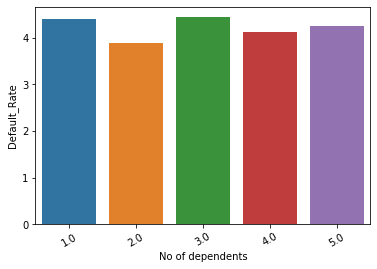

In [38]:
univariante_analysis(Demographic,Demographic['No of dependents'])

###### Analysis of Impact of No of dependents:-  
 - Applicants with 2 dependent are less likely to default 
 - Applicants with 3 dependent are more likely to default followed by applicants with 4 dependent
 - However there does not seem to be any significant impact of No of Dependent

Thus, there is `no significant` relation between `Default Rate` and `No of dependents of Applicant`

##### e.Income<a id="1.3e"></a>

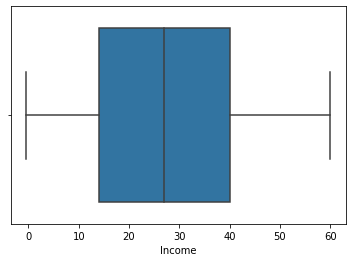

In [39]:
sns.boxplot(x='Income', data=Demographic)
plt.show()

In [40]:
# To understand the behaviour of people with income, we are going to bucket the income groups into brackets of 10 and 
# study the response rates

bins = np.arange(10,Demographic['Income'].max() + 10, 10)
Demographic['Income_bins'] = pd.cut(Demographic['Income'], bins, include_lowest=True)

     Income_bins  count_defaulters  No_of_Applicants  Default_Rate
0  (9.999, 20.0]             682.0             14649          4.66
1   (20.0, 30.0]             600.0             13563          4.42
2   (30.0, 40.0]             483.0             13614          3.55
3   (40.0, 50.0]             384.0             10820          3.55
4   (50.0, 60.0]             161.0              5601          2.87


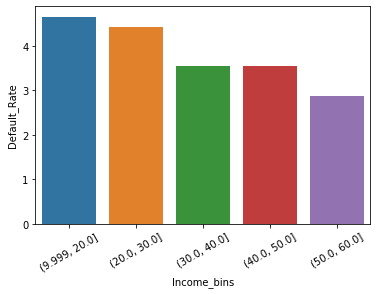

In [41]:
univariante_analysis(Demographic,Demographic['Income_bins'])

###### Analysis of Impact of Income:-  
 - Default Rate of applicants with low income is higher than the applicants with high income 
 - This is quite obvious as people with low income may tend to default due to unavailibity of money as compared to richer/high income class

There seems to be `significant` relation between `Default Rate` and `Income` of Applicant

##### f. Education<a id="1.3f"></a>

In [42]:
Demographic['Education'].value_counts()

Professional    24374
Masters         23472
Bachelor        17293
Phd              4461
Others            118
Name: Education, dtype: int64

      Education  count_defaulters  No_of_Applicants  Default_Rate
0      Bachelor             742.0             17293          4.29
1       Masters             998.0             23472          4.25
2        Others               8.0               118          6.78
3           Phd             183.0              4461          4.10
4  Professional            1011.0             24374          4.15


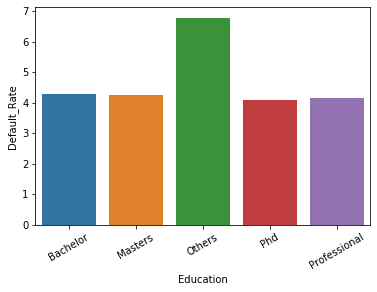

In [43]:
univariante_analysis(Demographic,Demographic['Education'])

###### Analysis of Impact of Education:-  
 - The default rate of people with education type as Others have highest default rate but number of applicant in for that group is quite low. hence it is not good idea to make any inference from it.
 - There is no significant difference between default rate of applicants with Education type as Bachelor , Master, PHD & Professional

There seems to be `no significant` relation between `Default Rate` and `Education` of Applicant

##### g.Profession<a id="1.3g"></a>

In [44]:
Demographic['Profession'].value_counts()

SAL        39606
SE_PROF    16213
SE         13899
Name: Profession, dtype: int64

  Profession  count_defaulters  No_of_Applicants  Default_Rate
0        SAL            1627.0             39606          4.11
1         SE             641.0             13899          4.61
2    SE_PROF             674.0             16213          4.16


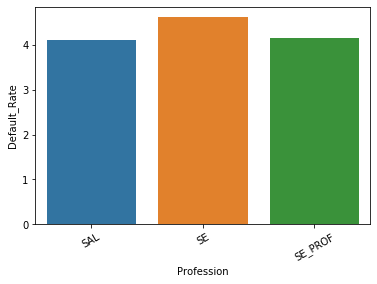

In [45]:
univariante_analysis(Demographic,Demographic['Profession'])

###### Analysis of Impact of Education:-  
 - The default rate of applicants who are self emloyed is higher compared to Salaried & Self Employed Prof

There seems `maybe` relation between `Default Rate` and `Profession` of Applicant

##### h.Type of residence<a id="1.3h"></a>

In [46]:
Demographic['Type of residence'].value_counts()

Rented                 52180
Owned                  13971
Living with Parents     1772
Company provided        1598
Others                   197
Name: Type of residence, dtype: int64

     Type of residence  count_defaulters  No_of_Applicants  Default_Rate
0     Company provided              72.0              1598          4.51
1  Living with Parents              80.0              1772          4.51
2               Others               5.0               197          2.54
3                Owned             592.0             13971          4.24
4               Rented            2193.0             52180          4.20


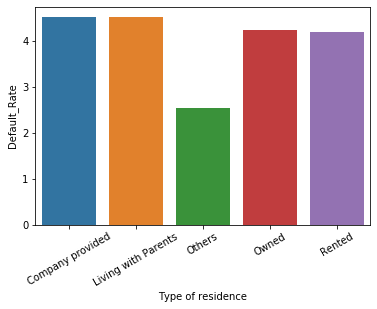

In [47]:
univariante_analysis(Demographic,Demographic['Type of residence'])

###### Analysis of Impact of Type of Residence:-  
 - The default rate of applicants who are self emloyed is higher compared to Salaried & Self Employed Prof

There seems `significanct` relation between `Default Rate` and `Profession` of Applicant

##### i. No of months in current residence<a id="3i"></a>

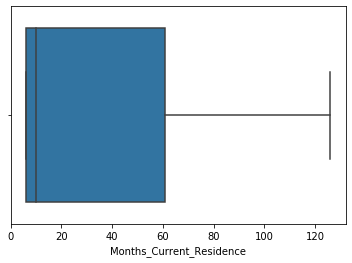

In [48]:
sns.boxplot(x='Months_Current_Residence', data=Demographic)
plt.show()

In [49]:
# To understand the behaviour of people with income, we are going to bucket the income groups into brackets of 10 and 
# study the response rates

bins = np.arange(10,Demographic['Months_Current_Residence'].max() + 10, 10)
Demographic['Current_Residence_bins'] = pd.cut(Demographic['Months_Current_Residence'], bins, include_lowest=True)

   Current_Residence_bins  count_defaulters  No_of_Applicants  Default_Rate
0           (9.999, 20.0]             286.0              4154          6.88
1            (20.0, 30.0]             227.0              3473          6.54
2            (30.0, 40.0]             200.0              3519          5.68
3            (40.0, 50.0]             178.0              3291          5.41
4            (50.0, 60.0]             168.0              3159          5.32
5            (60.0, 70.0]             129.0              2893          4.46
6            (70.0, 80.0]             136.0              2817          4.83
7            (80.0, 90.0]             126.0              2733          4.61
8           (90.0, 100.0]             119.0              2774          4.29
9          (100.0, 110.0]             108.0              2882          3.75
10         (110.0, 120.0]              90.0              2469          3.65
11         (120.0, 130.0]              50.0               919          5.44


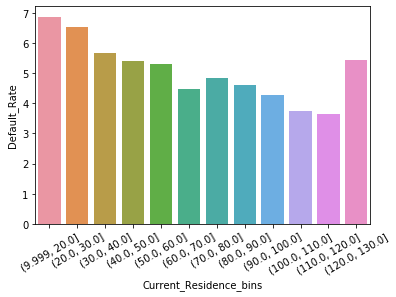

In [50]:
univariante_analysis(Demographic,Demographic['Current_Residence_bins'])

###### Analysis of Impact of No of Months in current residence:-  
 - The default rate of applicants who have less number of months in current residence is higher than applicants having higher number of months
 
There seems to `significant` relation between `Default Rate` and `No of Months in current residence` of Applicant

#### j.No of months in current company<a id="3j"></a>

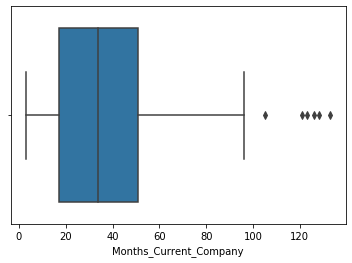

In [51]:
# We will create a box plot
sns.boxplot(x='Months_Current_Company', data=Demographic)
plt.show()

In [52]:
# Since there are a fair few data entries with `No of months in current company` > 100, we will club all of those `No of months in current company` at 50 
# we can assume that the behaviour will not change significantly with `No of months in current company` at age below 50

Demographic['Months_Current_Company'][Demographic['Months_Current_Company']>100] =50

In [53]:
# To understand the behaviour of people with `no of month in current company`, we are going to create bucketof 10 and 
# study the response rates

bins = np.arange(10,Demographic['Months_Current_Company'].max() + 10, 10)
Demographic['Current_Company_bins'] = pd.cut(Demographic['Months_Current_Company'], bins, include_lowest=True)

  Current_Company_bins  count_defaulters  No_of_Applicants  Default_Rate
0        (9.999, 20.0]             539.0             10782          5.00
1         (20.0, 30.0]             413.0             10026          4.12
2         (30.0, 40.0]             430.0             10176          4.23
3         (40.0, 50.0]             385.0             10243          3.76
4         (50.0, 60.0]             319.0             10089          3.16
5         (60.0, 70.0]             236.0              5567          4.24
6         (70.0, 80.0]             110.0              2277          4.83
7         (80.0, 90.0]               0.0                 1          0.00
8        (90.0, 100.0]               0.0                 2          0.00


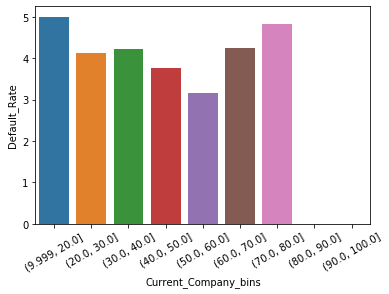

In [54]:
univariante_analysis(Demographic,Demographic['Current_Company_bins'])

###### Analysis of Impact of No of Months in current company:-  
 - The default rate of applicants who have less number of months in current company is higher than applicants having higher number of months  in current company
 - the default rate of applicants with number of months in current company as 70-80 is higher. But as the number of applicants in that group is lower, it is difficult to make any inference from it
 
There seems to `significant` relation between `Default Rate` and `No of Months in current company` of Applicant

### 2. Multivariante Analysis<a id="3B"></a>

##### Heatmap<a id="1.3k"></a>

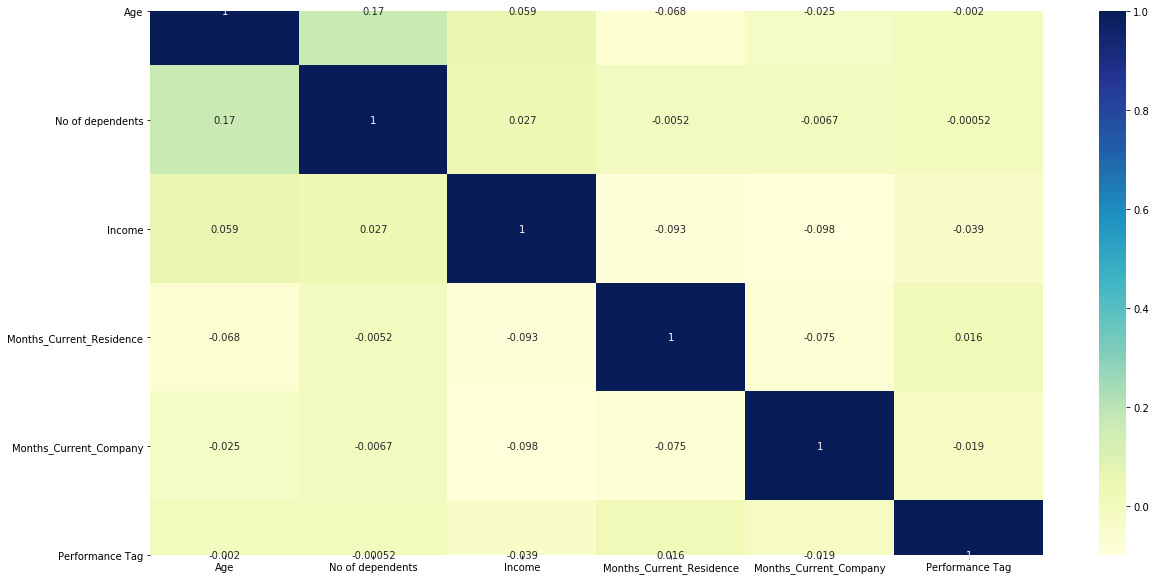

In [55]:
#Let us check if there is any correlation
plt.figure(figsize=(20, 10))
sns.heatmap(Demographic.drop(columns=['Application ID']).corr(), annot=True, cmap="YlGnBu")

###### Analysis of Heatmap:-  
 -  The Performance Tag(Default chance) is highly co related with `Income` , followed by `Months_Current_Residence` and `Months_Current_Company`
 - `No of Dependent` does not have significant co relation with The Performance Tag

### Step 4 :- Model Building on Non-WOE Demographic Dataset<a id="1.4"></a>

### Step 4(a) :- Data Preparation<a id="1.41"></a>

##### a.Drop unrequired column

In [56]:
# Droping the unwanted column
Demographic.drop(columns = 'Application ID', inplace = True)
Demographic.drop(columns = ['age_bins','Income_bins','Current_Residence_bins','Current_Company_bins'], inplace = True)

Notice that we have created a set of dummy columns for the feature job. Similarly, we are going to do the same for other categorical variables.

In [57]:
# Create Columns having dummy variables
Categorical_variable=['Gender','Marital Status','No of dependents','Education','Profession','Type of residence']
Dummy_Columns = pd.get_dummies(Demographic[Categorical_variable], drop_first = True)

In [58]:
# Add the dummy Columns to the original dataframe
Demographic = pd.concat([Demographic, Dummy_Columns], axis = 1)

In [59]:
# Drop Categorical as we have created the dummies for it
Demographic.drop(Categorical_variable, axis = 1, inplace = True)

In [60]:
Demographic.head()

,Age,Income,Months_Current_Residence,Months_Current_Company,Performance Tag,Gender_M,Marital Status_Single,Education_Masters,Education_Others,Education_Phd,Education_Professional,Profession_SE,Profession_SE_PROF,Type of residence_Living with Parents,Type of residence_Others,Type of residence_Owned,Type of residence_Rented
0,48,40.0,113,56,0.0,0,0,0,0,0,0,0,0,0,0,0,1
1,31,55.0,112,46,0.0,1,0,0,0,0,1,0,1,0,0,0,1
2,32,46.0,104,49,0.0,1,1,0,0,0,0,0,1,0,0,0,1
3,43,53.0,94,53,0.0,1,0,0,0,0,0,1,0,0,0,0,1
4,35,44.0,112,43,0.0,0,0,0,0,0,1,0,0,0,0,0,1


### Step 4(b):- Test Train Split<a id="1.42"></a>

In [61]:
# Putting feature variable to X
X = Demographic.drop(['Performance Tag'],axis=1)
# Putting response variable to y
y = Demographic['Performance Tag']

In [62]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

In [63]:
#create copy of X_train
X_train_copy=pd.DataFrame(X_train).copy()

### Step 4(c):- Standardisation<a id="1.43"></a>

In [64]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [65]:
# Create list of numerical variables
num_vars = ['Age','Income','Months_Current_Residence','Months_Current_Company']

In [66]:
# Apply scaler() to all the columns in `X_train`
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_train.head()

,Age,Income,Months_Current_Residence,Months_Current_Company,Gender_M,Marital Status_Single,Education_Masters,Education_Others,Education_Phd,Education_Professional,Profession_SE,Profession_SE_PROF,Type of residence_Living with Parents,Type of residence_Others,Type of residence_Owned,Type of residence_Rented
54282,0.787234,0.553719,0.233333,0.5375,1,0,1,0,0,0,0,0,0,0,0,1
4845,0.936170,0.768595,0.633333,0.1750,0,0,0,0,0,0,0,0,0,0,0,0
3896,0.680851,0.834711,0.358333,0.2625,1,0,1,0,0,0,0,0,0,0,0,1
30014,0.404255,0.082645,0.000000,0.8000,0,0,0,0,0,1,0,0,0,0,0,1
223,0.361702,0.917355,0.516667,0.5125,1,0,0,1,0,0,0,0,0,0,1,0


In [67]:
# Apply scaler() to all the columns in `X_test`
X_test[num_vars] = scaler.fit_transform(X_test[num_vars])
X_test.head()

,Age,Income,Months_Current_Residence,Months_Current_Company,Gender_M,Marital Status_Single,Education_Masters,Education_Others,Education_Phd,Education_Professional,Profession_SE,Profession_SE_PROF,Type of residence_Living with Parents,Type of residence_Others,Type of residence_Owned,Type of residence_Rented
11422,1.000000,0.388430,0.000000,0.311828,1,0,0,0,0,0,0,0,0,0,1,0
46793,0.297872,0.082645,0.533333,0.258065,1,0,1,0,0,0,0,0,0,0,1,0
52188,0.510638,0.504132,0.016667,0.204301,0,1,1,0,0,0,0,1,0,0,0,1
63986,0.234043,0.256198,0.000000,0.021505,1,0,0,0,0,1,0,0,0,0,0,1
46456,0.744681,0.206612,0.875000,0.344086,0,0,0,0,1,0,0,1,0,0,0,1


### Step 4(d) :- Model Building<a id="1.44"></a>

**Model 1** - `Building Logistic Model on NON WOE Demmographic Datset` 

#####  1 - Lets Build with all variables

In [68]:
#Create First Model
X_train1, lm1 , highest_pvalue_variable = get_model_and_print_summary(X_train)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                48802
Model:                            GLM   Df Residuals:                    48785
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8467.4
Date:                Mon, 16 Dec 2019   Deviance:                       16935.
Time:                        21:09:10   Pearson chi2:                 4.89e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

#### 2. Build model after dropping  variable `Type of residence_Owned`

In [69]:
#drop column having higher p value and rebuild the model again
X_train1, lm1 ,highest_pvalue_variable =  get_model_and_print_summary(X_train1.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                48802
Model:                            GLM   Df Residuals:                    48786
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8467.4
Date:                Mon, 16 Dec 2019   Deviance:                       16935.
Time:                        21:09:11   Pearson chi2:                 4.89e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

#Dropping `Type of residence_Rented` as it has high P-value

#### 3. Build model after dropping   `Type of residence_Rented`

In [70]:
#drop column having higher p value and rebuild the model again
X_train1, lm1 ,highest_pvalue_variable =  get_model_and_print_summary(X_train1.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                48802
Model:                            GLM   Df Residuals:                    48787
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8467.5
Date:                Mon, 16 Dec 2019   Deviance:                       16935.
Time:                        21:09:12   Pearson chi2:                 4.89e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

#### Model 4 :- Build model after dropping   `Profession_SE_PROF`

In [71]:
#drop column having higher p value and rebuild the model again
X_train1, lm1 ,highest_pvalue_variable =  get_model_and_print_summary(X_train1.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                48802
Model:                            GLM   Df Residuals:                    48788
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8467.5
Date:                Mon, 16 Dec 2019   Deviance:                       16935.
Time:                        21:09:14   Pearson chi2:                 4.89e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

#### Model 5 :- Build model after dropping  `Age`

In [72]:
#drop column having higher p value and rebuild the model again
X_train1, lm1 ,highest_pvalue_variable =  get_model_and_print_summary(X_train1.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                48802
Model:                            GLM   Df Residuals:                    48789
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8467.6
Date:                Mon, 16 Dec 2019   Deviance:                       16935.
Time:                        21:09:17   Pearson chi2:                 4.89e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

#### 6. Build model after dropping  `Marital Status_Single`

In [73]:
#drop column having higher p value and rebuild the model again
X_train1, lm1 ,highest_pvalue_variable =  get_model_and_print_summary(X_train1.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                48802
Model:                            GLM   Df Residuals:                    48790
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8467.7
Date:                Mon, 16 Dec 2019   Deviance:                       16935.
Time:                        21:09:19   Pearson chi2:                 4.89e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

#Dropping `Education_Masters` as it has high P-value

#### 7. Build model after dropping  `Education_Masters`

In [74]:
#drop column having higher p value and rebuild the model again
X_train1, lm1 ,highest_pvalue_variable =  get_model_and_print_summary(X_train1.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                48802
Model:                            GLM   Df Residuals:                    48791
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8467.9
Date:                Mon, 16 Dec 2019   Deviance:                       16936.
Time:                        21:09:21   Pearson chi2:                 4.89e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

#### 8. Build model after dropping  `Education_Phd`

In [75]:
#drop column having higher p value and rebuild the model again
X_train1, lm1 ,highest_pvalue_variable =  get_model_and_print_summary(X_train1.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                48802
Model:                            GLM   Df Residuals:                    48792
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8468.1
Date:                Mon, 16 Dec 2019   Deviance:                       16936.
Time:                        21:09:23   Pearson chi2:                 4.89e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

#### 9. Build model after dropping  `Type of residence_Living with Parents`

In [76]:
#drop column having higher p value and rebuild the model again
X_train1, lm1 ,highest_pvalue_variable =  get_model_and_print_summary(X_train1.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                48802
Model:                            GLM   Df Residuals:                    48793
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8468.3
Date:                Mon, 16 Dec 2019   Deviance:                       16937.
Time:                        21:09:25   Pearson chi2:                 4.89e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

#### 10. Build model after dropping  `Profession_SE`

In [77]:
#drop column having higher p value and rebuild the model again
X_train1, lm1 ,highest_pvalue_variable =  get_model_and_print_summary(X_train1.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                48802
Model:                            GLM   Df Residuals:                    48794
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8468.8
Date:                Mon, 16 Dec 2019   Deviance:                       16938.
Time:                        21:09:28   Pearson chi2:                 4.89e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

#### 11. Build model after dropping  `Education_Others`

In [78]:
#drop column having higher p value and rebuild the model again
X_train1, lm1 ,highest_pvalue_variable =  get_model_and_print_summary(X_train1.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                48802
Model:                            GLM   Df Residuals:                    48795
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8469.3
Date:                Mon, 16 Dec 2019   Deviance:                       16939.
Time:                        21:09:30   Pearson chi2:                 4.89e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

#Dropping `Type of residence_Others` as it has high P-value

#### 12. Build model after dropping  `Type of residence_Others`

In [79]:
#drop column having higher p value and rebuild the model again
X_train1, lm1 ,highest_pvalue_variable =  get_model_and_print_summary(X_train1.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                48802
Model:                            GLM   Df Residuals:                    48796
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8470.2
Date:                Mon, 16 Dec 2019   Deviance:                       16940.
Time:                        21:09:33   Pearson chi2:                 4.89e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

#### 13. Build model after dropping  `Education_Professional`

In [80]:
#drop column having higher p value and rebuild the model again
X_train1, lm1 ,highest_pvalue_variable =  get_model_and_print_summary(X_train1.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                48802
Model:                            GLM   Df Residuals:                    48797
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8471.1
Date:                Mon, 16 Dec 2019   Deviance:                       16942.
Time:                        21:09:36   Pearson chi2:                 4.89e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

#### 14. Build model after dropping  `Gender_M`

In [81]:
#drop column having higher p value and rebuild the model again
X_train1, lm1 ,highest_pvalue_variable =  get_model_and_print_summary(X_train1.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                48802
Model:                            GLM   Df Residuals:                    48798
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8472.0
Date:                Mon, 16 Dec 2019   Deviance:                       16944.
Time:                        21:09:38   Pearson chi2:                 4.89e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

#### 15. Build model after dropping  `Months_Current_Residence`

In [82]:
#drop column having higher p value and rebuild the model again
X_train1, lm1 ,highest_pvalue_variable =  get_model_and_print_summary(X_train1.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                48802
Model:                            GLM   Df Residuals:                    48799
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8473.8
Date:                Mon, 16 Dec 2019   Deviance:                       16948.
Time:                        21:09:42   Pearson chi2:                 4.89e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -2

In [83]:
get_vif(X_train1)

                 Features   VIF
0                   const  7.20
1                  Income  1.01
2  Months_Current_Company  1.01


**All variables have a good value of VIF. So we need not drop any more variables and we can proceed with making predictions using this model only**

In [84]:
X_train_final = X_train1
lm_final = lm1

#### i. Getting Top Predictors

In [85]:
top_predictor_variables=list(X_train_final.columns)
top_predictor_variables.remove('const')
print('The Top Predictors are :-')
top_predictor_variables

The Top Predictors are :-


['Income', 'Months_Current_Company']

#### ii. Draw ROC Curve

In [86]:
#Let's create a dataframe with lead score and converted values.
y_train_final = pd.DataFrame({'predicted_response':y_train.values, 'probablity_predicted_response':lm_final.predict(X_train_final)})
y_train_final.head()

,predicted_response,probablity_predicted_response
54282,0.0,0.036119
4845,0.0,0.034992
3896,0.0,0.032063
30014,0.0,0.047547
223,0.0,0.027192


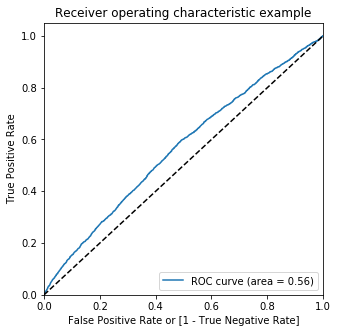

In [87]:
#draw roc curve
fpr, tpr, thresholds = roc_curve(y_train_final.predicted_response,y_train_final.probablity_predicted_response, drop_intermediate=False )
draw_roc(y_train_final.predicted_response, y_train_final.probablity_predicted_response)

#### iii.  Obtain Optimum Cutoff between sensitivity , specificity & Accuracy

In [88]:
numbers = [round(x * 0.05, 2) for x in range(0, 20)]

y_train_pred_final = y_train_final

for i in numbers:
    y_train_pred_final[i]= y_train_final.probablity_predicted_response.map(lambda x: 1 if x > i else 0)

y_train_pred_final.head()

,predicted_response,probablity_predicted_response,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,...,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95
54282,0.0,0.036119,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4845,0.0,0.034992,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3896,0.0,0.032063,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30014,0.0,0.047547,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
223,0.0,0.027192,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
#Lets create cut off dataframe having accuracy sensitivity & specificity
cutoff_df= create_cutoff_df(y_train_pred_final)
cutoff_df.head()

,Accuracy,Sensitivity,Specificity
0.00,0.042129,1.000000,0.000000
0.05,0.771341,0.282588,0.792838
0.10,0.957871,0.000000,1.000000
0.15,0.957871,0.000000,1.000000
0.20,0.957871,0.000000,1.000000


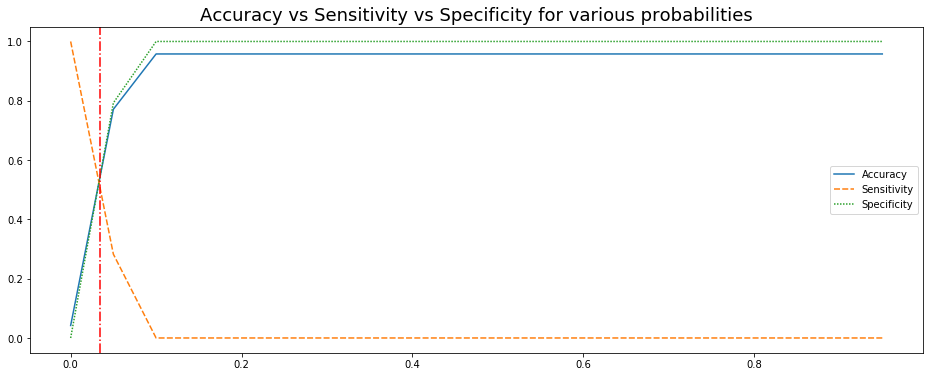

In [90]:
#Visualize accuracy, sensitivity and specificity graph
accuracy_sensitivity_specificty_graph(cutoff_df,0.034)

Graph Analysis :-  
`ROC curve shows that 0.034 is the optimum point to take it as a cutoff probability`

In [91]:
cutoff_probability = 0.034
predicted_final = y_train_pred_final.probablity_predicted_response.map( lambda x: 1 if x > cutoff_probability else 0)
Demo_LR_Non_Woe=metrics_dataframe(y_train_final.predicted_response, predicted_final)
Demo_LR_Non_Woe

Confusion Matrix is :-
[[10039 36707]
 [  320  1736]]
Metrics and their score for above confusion metris :-


,Metric,Score
0,Sensitivity/Recall,0.844358
1,Specificity,0.214756
2,Accuracy,0.241281
3,Precision,0.045158
4,False Positive Rate,0.785244
5,Positive Predictive Value,0.045158
6,Negative Predictive Value,0.969109


###### Analysis of Metrics of Logistic Model:-  
   - `Specificity` & `Accuracy` of `Random Forest` is below 25% which is quite low
   - But `Sensitivity/Recall` of `Random Forest` is `84%` which is quite good

 **Model 2** - `Building Random Forest Model on NON WOE Demmographic Datset`

##### A. Create Random Forest

In [92]:
#Create Random Forest
X_train=X_train_copy
rfc = RandomForestClassifier(class_weight ='balanced', n_jobs = -1)
rfc.fit(X_train, y_train)

#make predictions
y_predicted = rfc.predict(X_test)

#print metrics
print(classification_report(y_test, y_predicted))
metrics_dataframe(y_test, y_predicted)

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     20030
         1.0       0.00      0.00      0.00       886

    accuracy                           0.96     20916
   macro avg       0.48      0.50      0.49     20916
weighted avg       0.92      0.96      0.94     20916

Confusion Matrix is :-
[[20030     0]
 [  886     0]]
Metrics and their score for above confusion metris :-


,Metric,Score
0,Sensitivity/Recall,0.00000
1,Specificity,1.00000
2,Accuracy,0.95764
3,Precision,NaN
4,False Positive Rate,0.00000
5,Positive Predictive Value,NaN
6,Negative Predictive Value,0.95764


#### B. Hyper Parameter Tuning

In [93]:
param_grid = {
    'max_depth': [4, 8,16],
    'min_samples_leaf': range(5, 45, 10),
    'min_samples_split': range(10, 50, 10),
    'n_estimators': [10, 30, 50]
}

rfc = GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced'),
                        param_grid=param_grid,
                        scoring='accuracy',
                        cv=KFold(n_splits=3, shuffle=True, random_state=42),
                        n_jobs=-1,
                        verbose=1,
                        return_train_score=True) 
rfc.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  2.6min finished


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                             

In [94]:
print('Best Paramaters  :- ',rfc.best_params_)
print('Best Score  :- ',rfc.best_score_)
print('Best Estimators  :- ',rfc.best_estimator_)

Best Paramaters  :-  {'max_depth': 16, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 50}
Best Score  :-  0.948506208761936
Best Estimators  :-  RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=16, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=50, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)


##### C. Building Final Random Forest

In [95]:
rfc_final = RandomForestClassifier(bootstrap=True, class_weight='balanced',criterion='gini',
                       max_depth=rfc.best_estimator_.max_depth, 
                       min_samples_leaf=rfc.best_estimator_.min_samples_leaf,
                       min_samples_split=rfc.best_estimator_.min_samples_split,
                       n_estimators=rfc.best_estimator_.n_estimators,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_weight_fraction_leaf=0.0,
                        n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

rfc_final.fit(X_train, y_train)
y_predicted = rfc_final.predict(X_test)

In [96]:
print(classification_report(y_test, y_predicted))
Demo_RF_Non_Woe=metrics_dataframe(y_test, y_predicted)
Demo_RF_Non_Woe

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     20030
         1.0       0.00      0.00      0.00       886

    accuracy                           0.96     20916
   macro avg       0.48      0.50      0.49     20916
weighted avg       0.92      0.96      0.94     20916

Confusion Matrix is :-
[[20030     0]
 [  886     0]]
Metrics and their score for above confusion metris :-


,Metric,Score
0,Sensitivity/Recall,0.00000
1,Specificity,1.00000
2,Accuracy,0.95764
3,Precision,NaN
4,False Positive Rate,0.00000
5,Positive Predictive Value,NaN
6,Negative Predictive Value,0.95764


###### Analysis of Metrics of Random Forest for Demographic Dataset (without WOE Imputation):-  
   - `Specificity` & `Accuracy` of `Random Forest` is above 95% which is quite good
   - But `Sensitivity/Recall` of `Random Forest` is `0%` which is not acceptable

### Step 5 :- Model Building on WOE Demographic Dataset<a id="1.5"></a>

### Step 5(a) :- Calculating Woe & IV value for Demographic Dataset <a id="1.51">

In [97]:
Demographics_Without_Imputation=Demographic_copy
## calculate woe and iv for demographics data (without any imputation)
Demographics_IV, Demographics_WOE = calculate_WOE_IV(data = Demographics_Without_Imputation.drop(['Application ID'],axis=1), 
                                           target = 'Performance Tag', bins=8, show_woe = True)



Information value of Age is 0.004586
  Variable          Cutoff  Number  Defaults  Defaults(%)  Non-Defaults  \
0      Age  (-3.001, 32.0]    8726     370.0     0.125509        8356.0   
1      Age    (32.0, 37.0]    8758     370.0     0.125509        8388.0   
2      Age    (37.0, 41.0]    9446     437.0     0.148236        9009.0   
3      Age    (41.0, 45.0]    9238     375.0     0.127205        8863.0   
4      Age    (45.0, 49.0]    9090     398.0     0.135007        8692.0   
5      Age    (49.0, 53.0]    9093     333.0     0.112958        8760.0   
6      Age    (53.0, 57.0]    7620     335.0     0.113636        7285.0   
7      Age    (57.0, 65.0]    7899     330.0     0.111940        7569.0   

   Non-Defaults(%)       WOE        IV  
0         0.124862  0.005169  0.000003  
1         0.125340  0.001346  0.000000  
2         0.134619  0.096355  0.001312  
3         0.132438 -0.040314  0.000211  
4         0.129883  0.038694  0.000198  
5         0.130899 -0.147408  0.002645 

In [98]:
## Check WoE and IV values for all variables for demographics data set
Demographics_WOE.sort_values(by=['Variable','WOE'], ascending = False)

,Cutoff,Defaults,Defaults(%),IV,Non-Defaults,Non-Defaults(%),Number,Variable,WOE,max_val,min_val
2,NULL,0.0,0.000170,0.000018,8.0,0.000120,8,Type of residence,0.349812,0.0,0.000
0,Company provided,73.0,0.024763,0.000152,1530.0,0.022862,1603,Type of residence,0.079837,0.0,0.000
1,Living with Parents,80.0,0.027137,0.000119,1698.0,0.025373,1778,Type of residence,0.067221,0.0,0.000
4,Owned,593.0,0.201153,0.000003,13410.0,0.200383,14003,Type of residence,0.003839,0.0,0.000
5,Rented,2197.0,0.745251,0.000013,50083.0,0.748379,52280,Type of residence,-0.004188,0.0,0.000
3,Others,5.0,0.001696,0.000631,193.0,0.002884,198,Type of residence,-0.530851,0.0,0.000
2,SE,642.0,0.217775,0.001783,13285.0,0.198515,13927,Profession,0.092598,0.0,0.000
3,SE_PROF,677.0,0.229647,0.000043,15579.0,0.232793,16256,Profession,-0.013607,0.0,0.000
1,SAL,1629.0,0.552578,0.000452,38045.0,0.568498,39674,Profession,-0.028403,0.0,0.000
0,NULL,0.0,0.000170,0.000003,13.0,0.000194,13,Profession,-0.135696,0.0,0.000


In [99]:
## displaying the consolidate IV values for each variable in demographics data set
Demographics_IV.sort_values(by='IV', ascending = False)

,Variable,IV
0,Months_Current_Residence,0.069768
0,Income,0.038978
0,Months_Current_Company,0.019706
0,Age,0.004586
0,No of dependents,0.002823
0,Profession,0.002281
0,Type of residence,0.000936
0,Education,0.000765
0,Gender,0.000562
0,Marital Status,0.000143


The above dataframe shows that `Months_Current_Residence` have highest predictive power followed by `Income` & `Months_Current_Company`

In [100]:
## evaluating the overall IV for the dataset
Demographics_IV.IV.sum()

0.140548

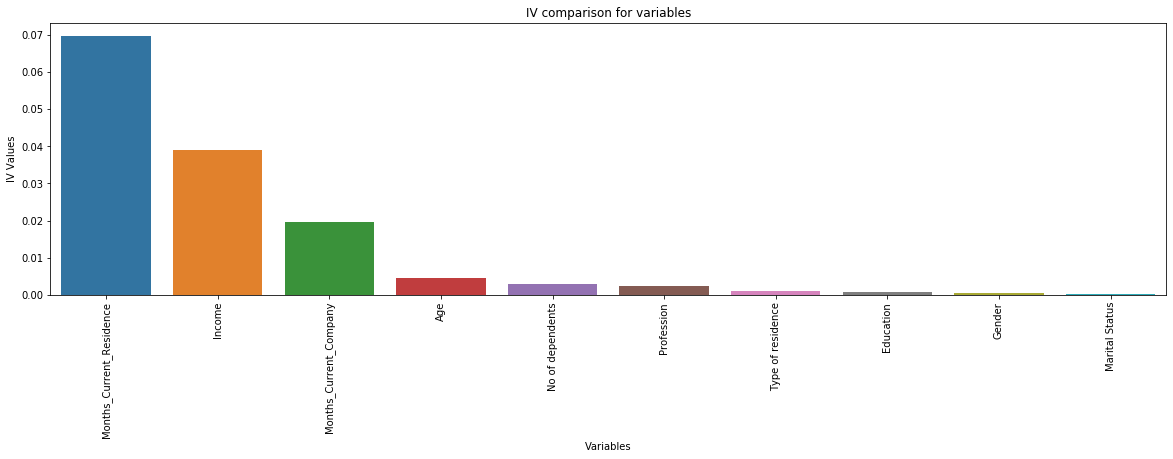

In [101]:
## plotting all the consolidated IV values of the demographics variable
plt.figure(figsize=(20,5))
ax = sns.barplot(x='Variable', y='IV', data=Demographics_IV.sort_values(by='IV', ascending = False))
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('IV comparison for variables')
plt.xlabel('Variables')
plt.ylabel('IV Values')
plt.show()

The Months_Current_Residence have more prediction power compared to other demographics variable

### Step 5(b) :- Create Woe Dataframe<a id="1.52"></a>

In [102]:
## creating demographics WoE dataframe from original demographics dataframe
WOE_Demographic_df = create_woe_dataframe(Demographics_Without_Imputation,Demographics_WOE)
WOE_Demographic_df.head()

,Application ID,Age,Gender,Marital Status,No of dependents,Income,Education,Profession,Type of residence,Months_Current_Residence,Months_Current_Company,Performance Tag
0,954457215.0,0.038694,0.031865,-0.003932,-0.085531,-0.205522,0.017005,-0.028403,-0.004188,-0.063524,-0.294821,0.0
1,432830445.0,0.005169,-0.010008,-0.003932,-0.025688,-0.330883,-0.018326,-0.013607,-0.004188,-0.063524,-0.148023,0.0
2,941387308.0,0.005169,-0.010008,0.023017,-0.085531,-0.179070,0.017005,-0.013607,-0.004188,-0.063524,-0.148023,0.0
3,392161677.0,-0.040314,-0.010008,-0.003932,0.039776,-0.330883,0.017005,0.092598,-0.004188,-0.063524,-0.294821,0.0
4,182011211.0,0.001346,0.031865,-0.003932,0.006068,-0.179070,-0.018326,-0.028403,-0.004188,-0.063524,-0.148023,0.0


In [103]:
#lets remove unrequired columns
WOE_Demographic_df= WOE_Demographic_df.drop(['Application ID'],axis=1)

### Step 5(c) :- Test Train Split<a id="1.53"></a>

In [104]:
# Putting feature variable to X
X = WOE_Demographic_df.drop(['Performance Tag'],axis=1)
# Putting response variable to y
y = WOE_Demographic_df['Performance Tag']

In [105]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

In [106]:
#create copy of X_train
X_train_copy=pd.DataFrame(X_train).copy()

### Step 5(d) :- Building  Model with Demographic Data(with WOE imputation) <a id="1.54">

 **Model 1** - `Building Logistic Regression Model on WOE Demographic Dataset`

##### 1. Lets Build with all variables

In [107]:
# Lets Build with all variables

X_train1, lm1 , highest_pvalue_variable= get_model_and_print_summary(X_train)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                49906
Model:                            GLM   Df Residuals:                    49895
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8340.6
Date:                Mon, 16 Dec 2019   Deviance:                       16681.
Time:                        21:13:01   Pearson chi2:                 4.98e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

##### 2. Rebuild model after dropping `Marital Status`

In [108]:
#drop column having higher p value and rebuild the model again
X_train1, lm1 ,highest_pvalue_variable = get_model_and_print_summary(X_train1.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                49906
Model:                            GLM   Df Residuals:                    49896
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8340.6
Date:                Mon, 16 Dec 2019   Deviance:                       16681.
Time:                        21:13:01   Pearson chi2:                 4.98e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

##### 3. Rebuild model after dropping `Type of residence`

In [109]:
#drop column having higher p value and rebuild the model again
X_train1, lm1 ,highest_pvalue_variable = get_model_and_print_summary(X_train1.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                49906
Model:                            GLM   Df Residuals:                    49897
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8340.8
Date:                Mon, 16 Dec 2019   Deviance:                       16682.
Time:                        21:13:01   Pearson chi2:                 4.98e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

##### 4. Rebuild model after dropping `Education`

In [110]:
#drop column having higher p value and rebuild the model again
X_train1, lm1 ,highest_pvalue_variable = get_model_and_print_summary(X_train1.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                49906
Model:                            GLM   Df Residuals:                    49898
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8341.1
Date:                Mon, 16 Dec 2019   Deviance:                       16682.
Time:                        21:13:01   Pearson chi2:                 4.98e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

##### 5. Rebuild model after dropping `No of dependents`

In [111]:
#drop column having higher p value and rebuild the model again
X_train1, lm1 ,highest_pvalue_variable = get_model_and_print_summary(X_train1.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                49906
Model:                            GLM   Df Residuals:                    49899
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8341.6
Date:                Mon, 16 Dec 2019   Deviance:                       16683.
Time:                        21:13:02   Pearson chi2:                 4.98e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

##### 6. Rebuild model after dropping `Education`

In [112]:
#drop column having higher p value and rebuild the model again
X_train1, lm1 ,highest_pvalue_variable = get_model_and_print_summary(X_train1.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                49906
Model:                            GLM   Df Residuals:                    49900
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8342.3
Date:                Mon, 16 Dec 2019   Deviance:                       16685.
Time:                        21:13:02   Pearson chi2:                 4.98e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

##### 7. Rebuild model after dropping `Profession`

In [113]:
#drop column having higher p value and rebuild the model again
X_train1, lm1 ,highest_pvalue_variable = get_model_and_print_summary(X_train1.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                49906
Model:                            GLM   Df Residuals:                    49901
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8344.1
Date:                Mon, 16 Dec 2019   Deviance:                       16688.
Time:                        21:13:02   Pearson chi2:                 4.98e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [114]:
get_vif(X_train1)

                   Features   VIF
0                     const  1.02
2                    Income  1.02
3  Months_Current_Residence  1.02
1                       Age  1.00
4    Months_Current_Company  1.00


**All variables have a good value of VIF. So we need not drop any more variables and we can proceed with making predictions using this model only**

In [115]:
X_train_final = X_train1
lm_final = lm1

#### i. Getting Top Predictors

In [116]:
top_predictor_variables=list(X_train_final.columns)
top_predictor_variables.remove('const')
print('The Top Predictors are :-')
top_predictor_variables

The Top Predictors are :-


['Age', 'Income', 'Months_Current_Residence', 'Months_Current_Company']

####  ii. Draw ROC Curve

In [117]:
#Let's create a dataframe with lead score and converted values.
y_train_final = pd.DataFrame({'predicted_response':y_train.values, 'probablity_predicted_response':lm_final.predict(X_train_final)})
y_train_final.head()

,predicted_response,probablity_predicted_response
20641,1.0,0.036897
64728,0.0,0.041220
7706,0.0,0.033034
60648,0.0,0.047167
58512,0.0,0.041459


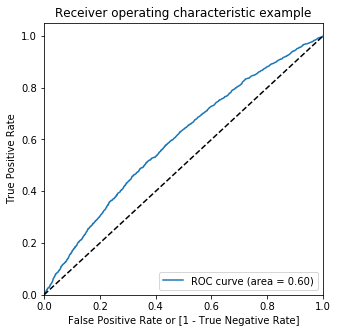

In [118]:
fpr, tpr, thresholds = roc_curve(y_train_final.predicted_response,y_train_final.probablity_predicted_response, drop_intermediate=False )
draw_roc(y_train_final.predicted_response, y_train_final.probablity_predicted_response)

#### iii.  Obtain Optimum Cutoff between sensitivity , specificity & Accuracy

In [119]:
numbers = [round(x * 0.05, 2) for x in range(0, 20)]

y_train_pred_final = y_train_final

for i in numbers:
    y_train_pred_final[i]= y_train_final.probablity_predicted_response.map(lambda x: 1 if x > i else 0)

y_train_pred_final.head()

,predicted_response,probablity_predicted_response,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,...,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95
20641,1.0,0.036897,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64728,0.0,0.041220,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7706,0.0,0.033034,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60648,0.0,0.047167,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58512,0.0,0.041459,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [120]:
#Let us create function for accuracy, sensitivity and specificity

cutoff_df = pd.DataFrame(columns=['Accuracy', 'Sensitivity','Specificity'])

for i in numbers:
    confusion = confusion_matrix(y_train_pred_final.predicted_response, y_train_pred_final[i] )
    total=sum(sum(confusion))
    accuracy = (confusion[0,0]+confusion[1,1])/total
    
    specificity = confusion[0,0]/(confusion[0,0]+confusion[0,1])
    sensitivity = confusion[1,1]/(confusion[1,0]+confusion[1,1])
    cutoff_df.loc[i] =[accuracy, sensitivity, specificity]
    
cutoff_df.head()

,Accuracy,Sensitivity,Specificity
0.00,0.040436,1.000000,0.000000
0.05,0.771911,0.316155,0.791117
0.10,0.959564,0.000000,1.000000
0.15,0.959564,0.000000,1.000000
0.20,0.959564,0.000000,1.000000


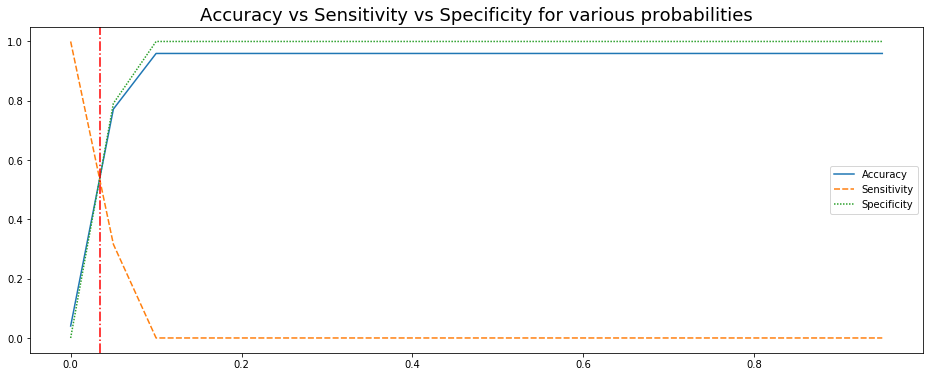

In [121]:
#Visualize accuracy, sensitivity and specificity
accuracy_sensitivity_specificty_graph(cutoff_df,0.034)

Graph Analysis :-  
`ROC curve shows that 0.034 is the optimum point to take it as a cutoff probability`

In [122]:
cutoff_probability = 0.034
predicted_final = y_train_pred_final.probablity_predicted_response.map( lambda x: 1 if x > cutoff_probability else 0)
Demo_LR_Woe=metrics_dataframe(y_train_final.predicted_response, predicted_final)
Demo_LR_Woe

Confusion Matrix is :-
[[18488 29400]
 [  526  1492]]
Metrics and their score for above confusion metris :-


,Metric,Score
0,Sensitivity/Recall,0.739346
1,Specificity,0.386067
2,Accuracy,0.400353
3,Precision,0.048297
4,False Positive Rate,0.613933
5,Positive Predictive Value,0.048297
6,Negative Predictive Value,0.972336


###### Analysis of Metrics of Logistic Model on WOE Demographic Dataset:-  
   - `Specificity` & `Accuracy` of `Random Forest` is below `40%` which is quite low
   - But `Sensitivity/Recall` of `Random Forest` is around `73%` which is quite good

 **Model 2** - `Building Random Forest Model on  WOE Demmographic Datset`

##### A. Create Random Forest

In [123]:
#Create Random Forest
X_train=X_train_copy
rfc = RandomForestClassifier(class_weight ='balanced', n_jobs = -1)
rfc.fit(X_train, y_train)

#make predictions
y_predicted = rfc.predict(X_test)

#check metrics
print(classification_report(y_test, y_predicted))
metrics_dataframe(y_test, y_predicted)

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     20459
         1.0       0.04      0.01      0.01       930

    accuracy                           0.95     21389
   macro avg       0.50      0.50      0.49     21389
weighted avg       0.92      0.95      0.93     21389

Confusion Matrix is :-
[[20302   157]
 [  923     7]]
Metrics and their score for above confusion metris :-


,Metric,Score
0,Sensitivity/Recall,0.007527
1,Specificity,0.992326
2,Accuracy,0.949507
3,Precision,0.042683
4,False Positive Rate,0.007674
5,Positive Predictive Value,0.042683
6,Negative Predictive Value,0.956514


#### B. Hyper Parameter Tuning

In [124]:
param_grid = {
    'max_depth': [2, 4, 8],
    'min_samples_leaf': range(10, 50, 10),
    'min_samples_split': range(10, 50, 10),
    'n_estimators': [10, 30, 50]
}

rfc = GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced'),
                        param_grid=param_grid,
                        scoring='recall',
                        cv=KFold(n_splits=3, shuffle=True, random_state=42),
                        n_jobs=-1,
                        verbose=1,
                        return_train_score=True) 
rfc.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  2.0min finished


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                             

In [125]:
print('Best Paramaters  :- ',rfc.best_params_)
print('Best Score  :- ',rfc.best_score_)
print('Best Estimators  :- ',rfc.best_estimator_)

Best Paramaters  :-  {'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 10}
Best Score  :-  0.5512500529874044
Best Estimators  :-  RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=10,
                       min_samples_split=20, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)


##### C. Building Final Random Forest

In [126]:
rfc_final = RandomForestClassifier(bootstrap=True, class_weight='balanced',criterion='gini',
                       max_depth=rfc.best_estimator_.max_depth, 
                       max_features=rfc.best_estimator_.max_features,
                       min_samples_leaf=rfc.best_estimator_.min_samples_leaf,
                       min_samples_split=rfc.best_estimator_.min_samples_split,
                       n_estimators=rfc.best_estimator_.n_estimators,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_weight_fraction_leaf=0.0,
                        n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

rfc_final.fit(X_train, y_train)
y_predicted = rfc_final.predict(X_test)

In [127]:
print(classification_report(y_test, y_predicted))
Demo_RF_Woe=metrics_dataframe(y_test, y_predicted)
Demo_RF_Woe

              precision    recall  f1-score   support

         0.0       0.96      0.64      0.77     20459
         1.0       0.06      0.49      0.10       930

    accuracy                           0.63     21389
   macro avg       0.51      0.56      0.44     21389
weighted avg       0.93      0.63      0.74     21389

Confusion Matrix is :-
[[13027  7432]
 [  476   454]]
Metrics and their score for above confusion metris :-


,Metric,Score
0,Sensitivity/Recall,0.488172
1,Specificity,0.636737
2,Accuracy,0.630277
3,Precision,0.057570
4,False Positive Rate,0.363263
5,Positive Predictive Value,0.057570
6,Negative Predictive Value,0.964749


###### Analysis of Metrics of Random Forest on WOE Demographic Dataset:-  
   - `Specificity` & `Accuracy` of `Random Forest` is above `60%` which is quite good
   - But `Sensitivity/Recall` of `Random Forest` is around `50%` which is quite low

 **Model 3** - `Building Decision Tree on WOE Demographic Dataset`

##### i. Building Decision Tree

In [128]:
param_grid = {
    'max_depth': [2, 4, 8, 16],
    'min_samples_leaf': range(10, 50, 10),
    'min_samples_split': range(10, 50, 10),
    'max_features': range(10, 15, 10)
}

dt = GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced'),
                        param_grid=param_grid,
                        scoring='recall',
                        cv=KFold(n_splits=5, shuffle=True, random_state=42),
                        n_jobs=-1,
                        verbose=1,
                        return_train_score=True) 

#dt.fit(telecom.drop('churn', axis=1), telecom['churn'])
dt.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:   19.4s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [2, 4, 8, 16],
                   

In [129]:
#Check best Parameters
print(dt.best_score_)
print(dt.best_params_)

0.5060889315019765
{'max_depth': 8, 'max_features': 10, 'min_samples_leaf': 40, 'min_samples_split': 10}


##### ii. Building Decision tree with best parameters

In [130]:
#Building Decision tree
decision_tree_final = DecisionTreeClassifier(class_weight='balanced', max_depth=dt.best_params_['max_depth'],
                                       min_samples_leaf=dt.best_params_['min_samples_leaf'],
                                       min_samples_split=dt.best_params_['min_samples_split'],
                                       max_features=dt.best_params_['max_features'],random_state=42)

decision_tree_final.fit(X_train, y_train)

#Making Prediction
y_predicted = decision_tree_final.predict(X_test)

#Check Metrics
#print(classification_report(y_test, y_predicted))
Demo_DT_Woe=metrics_dataframe(y_test, y_predicted)
Demo_DT_Woe

Confusion Matrix is :-
[[10232 10227]
 [  397   533]]
Metrics and their score for above confusion metris :-


,Metric,Score
0,Sensitivity/Recall,0.573118
1,Specificity,0.500122
2,Accuracy,0.503296
3,Precision,0.049535
4,False Positive Rate,0.499878
5,Positive Predictive Value,0.049535
6,Negative Predictive Value,0.962649


###### Analysis of Metrics of Decision trees on WOE Demo Dataset:-  
   -  `Sensitivity/Recall` is higher than  `50%` which is quite good
   -  `Specificity` & `Accuracy` is higher than  `50%` which is quite low
   - `Precision`  is `4%` which is also quite low


In [131]:
##### Checking Top features of Decision Tree
Top_Features_df = pd.DataFrame(list(zip(list(X_train.columns)[:-1], decision_tree_final.feature_importances_)),
             columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

Top_Features_df.head()

,Feature,Importance
8,Months_Current_Residence,0.193766
0,Age,0.144774
4,Income,0.137229
3,No of dependents,0.111674
7,Type of residence,0.072225


#### Impotant Finding from all above Models built with demographic datasets
- The important predictors from demographic dataset are:-          
     1.Age     
     2.Income           
     3.Months_Current_Residence     
     4.Months_Current_Company   
     5.No of dependents

#### Note
   - The aim of building model with Demographic Dataset was to understand predictive power of the application data which we have understood from the above  models. Hence we can stop building model with demographic dataset till here.  
   -  We will not be deciding if applicant is defaulter or not on basis of above models
   -  With help of model build with master dataset (credit +demographic)not to decide if applicant is defaulter or not

##  Part 3 :- `Building Model on Demographic Data + Credit Data` <a id="2"></a>

### Step 1 :- Data Importing & Data Understanding <a id="2.1"></a>

##### i. Importing Csv File

In [132]:
Credit = pd.read_csv("Credit Bureau data.csv", sep=",")
Credit.head()

,Application ID,No of times 90 DPD or worse in last 6 months,No of times 60 DPD or worse in last 6 months,No of times 30 DPD or worse in last 6 months,No of times 90 DPD or worse in last 12 months,No of times 60 DPD or worse in last 12 months,No of times 30 DPD or worse in last 12 months,Avgas CC Utilization in last 12 months,No of trades opened in last 6 months,No of trades opened in last 12 months,No of PL trades opened in last 6 months,No of PL trades opened in last 12 months,No of Inquiries in last 6 months (excluding home & auto loans),No of Inquiries in last 12 months (excluding home & auto loans),Presence of open home loan,Outstanding Balance,Total No of Trades,Presence of open auto loan,Performance Tag
0,954457215,0,0,0,0,0,0,4.0,1.0,2,0,0,0,0,1.0,2999395.0,4,0,0.0
1,432830445,0,0,0,0,0,0,3.0,1.0,2,0,0,0,0,0.0,3078.0,5,0,0.0
2,941387308,0,0,0,0,0,0,7.0,0.0,0,0,0,0,0,1.0,3004972.0,2,0,0.0
3,392161677,0,0,0,0,0,0,11.0,1.0,1,0,0,0,0,1.0,3355373.0,4,1,0.0
4,182011211,0,0,0,0,0,0,12.0,0.0,1,0,0,0,0,1.0,3014283.0,4,0,0.0


In [133]:
Credit = Credit.rename(columns = {"No of times 90 DPD or worse in last 6 months":"90DPD_6Months",
                                  "No of times 60 DPD or worse in last 6 months":"60DPD_6Months",
                                  "No of times 30 DPD or worse in last 6 months":"30DPD_6Months",
                                  "No of times 90 DPD or worse in last 12 months":"90DPD_12Months",
                                  "No of times 60 DPD or worse in last 12 months":"60DPD_12Months",
                                  "No of times 30 DPD or worse in last 12 months":"30DPD_12Months",
                                  "No of trades opened in last 6 months":"Trades_6Months",
                                  "No of trades opened in last 12 months":"Trades_12Months",
                                  "No of PL trades opened in last 6 months":"PL_Trades_6Months",
                                  "No of PL trades opened in last 12 months":"PL_Trades_12Months",                                  
                                  "No of Inquiries in last 6 months (excluding home & auto loans)": "Enquires_6Months",
                                  "No of Inquiries in last 12 months (excluding home & auto loans)": "Enquires_12Months",
                                  "Presence of open home loan":"Home_Loan_Present",
                                  "Presence of open auto loan":"Auto_Loan_Present",
                                 "Avgas CC Utilization in last 12 months":"Avgas_Utilization_12Months"})

##### ii. Inspect the various aspects of the  dataframe

In [134]:
Credit.shape

(71295, 19)

In [135]:
# Looking at all the column names
Credit.columns

Index(['Application ID', '90DPD_6Months', '60DPD_6Months', '30DPD_6Months',
       '90DPD_12Months', '60DPD_12Months', '30DPD_12Months',
       'Avgas_Utilization_12Months', 'Trades_6Months', 'Trades_12Months',
       'PL_Trades_6Months', 'PL_Trades_12Months', 'Enquires_6Months',
       'Enquires_12Months', 'Home_Loan_Present', 'Outstanding Balance',
       'Total No of Trades', 'Auto_Loan_Present', 'Performance Tag'],
      dtype='object')

#### iv. Create Master Dataframe

In [136]:
#Creating master dataframe
Master =Credit.merge(Demographic_copy.drop(['Performance Tag'], axis=1),how='inner', on='Application ID')
Master.shape

(71301, 29)

In [137]:
# Looking at all the column names
Master.columns

Index(['Application ID', '90DPD_6Months', '60DPD_6Months', '30DPD_6Months',
       '90DPD_12Months', '60DPD_12Months', '30DPD_12Months',
       'Avgas_Utilization_12Months', 'Trades_6Months', 'Trades_12Months',
       'PL_Trades_6Months', 'PL_Trades_12Months', 'Enquires_6Months',
       'Enquires_12Months', 'Home_Loan_Present', 'Outstanding Balance',
       'Total No of Trades', 'Auto_Loan_Present', 'Performance Tag', 'Age',
       'Gender', 'Marital Status', 'No of dependents', 'Income', 'Education',
       'Profession', 'Type of residence', 'Months_Current_Residence',
       'Months_Current_Company'],
      dtype='object')

In [138]:
#Creating copy of Demographic Dataframe for further analysis
Master_copy=pd.DataFrame(Master).copy()

### Step 2 :-  Data Cleaning

##### i.Remove Duplicate Rows

In [139]:
#Check number of records before dropping duplicate records
print('Total Number of Records before dropping duplicate records:- ',Master['Application ID'].count())

#drop Records having duplicate values
Master = Master.drop_duplicates(['Application ID'])

#Check number of records after dropping duplicate records
print('Total Number of Records after dropping duplicate records:- ',Master['Application ID'].count())

Total Number of Records before dropping duplicate records:-  71301
Total Number of Records after dropping duplicate records:-  71292


There were 3 duplicate records

##### ii. Check Column wise Missing values

In [140]:
#Let us check the null values
Master.isnull().sum(axis=0).sort_values(ascending=False)

Performance Tag               1425
Avgas_Utilization_12Months    1058
Home_Loan_Present              272
Outstanding Balance            272
Education                      119
Profession                      14
Type of residence                8
Marital Status                   6
No of dependents                 3
Gender                           2
Trades_6Months                   1
30DPD_6Months                    0
90DPD_12Months                   0
Trades_12Months                  0
60DPD_12Months                   0
30DPD_12Months                   0
90DPD_6Months                    0
60DPD_6Months                    0
Months_Current_Company           0
PL_Trades_6Months                0
PL_Trades_12Months               0
Enquires_6Months                 0
Enquires_12Months                0
Months_Current_Residence         0
Total No of Trades               0
Auto_Loan_Present                0
Age                              0
Income                           0
Application ID      

In [141]:
# Records having missing value of Performance Tag are of no value as this is the depedent variable.Hence droppping the variable 
Master.dropna(subset=['Performance Tag'],inplace=True)

#Let us check the null values after dropping records having missing value in 'Performance Tag' column
Master.isnull().sum(axis=0).sort_values(ascending=False)

Avgas_Utilization_12Months    1023
Home_Loan_Present              272
Outstanding Balance            272
Education                      118
Profession                      13
Type of residence                8
Marital Status                   6
No of dependents                 3
Gender                           2
Trades_6Months                   1
60DPD_12Months                   0
30DPD_12Months                   0
60DPD_6Months                    0
90DPD_12Months                   0
30DPD_6Months                    0
PL_Trades_6Months                0
90DPD_6Months                    0
Trades_12Months                  0
Months_Current_Company           0
PL_Trades_12Months               0
Enquires_6Months                 0
Enquires_12Months                0
Months_Current_Residence         0
Total No of Trades               0
Auto_Loan_Present                0
Performance Tag                  0
Age                              0
Income                           0
Application ID      

In [142]:
# Number of Records having missing value of  in columns like Outstanding Balance, Profession Type of Residence, Marital Status,No of dependents & Gender is very small compared to total number of Records
# Hence lets drop these records also
Master.dropna(subset=['Avgas_Utilization_12Months','Home_Loan_Present','Outstanding Balance','Trades_6Months'],inplace=True)
Master.dropna(subset=['Education','Profession','Type of residence','Marital Status','No of dependents','Gender'],inplace=True)

In [143]:
#Let us check the null values after missing records
Master.isnull().sum(axis=0).sort_values(ascending=False)

Months_Current_Company        0
Enquires_12Months             0
90DPD_6Months                 0
60DPD_6Months                 0
30DPD_6Months                 0
90DPD_12Months                0
60DPD_12Months                0
30DPD_12Months                0
Avgas_Utilization_12Months    0
Trades_6Months                0
Trades_12Months               0
PL_Trades_6Months             0
PL_Trades_12Months            0
Enquires_6Months              0
Home_Loan_Present             0
Months_Current_Residence      0
Outstanding Balance           0
Total No of Trades            0
Auto_Loan_Present             0
Performance Tag               0
Age                           0
Gender                        0
Marital Status                0
No of dependents              0
Income                        0
Education                     0
Profession                    0
Type of residence             0
Application ID                0
dtype: int64

In [144]:
Master.shape

(68696, 29)

Percentage of Records left after Data Cleaning = 68696/71292 =96.35% 
Due to Data Cleaning around 3.65% data is lost which is not much significant           
Lets Proceed Futher with Data Exploration 

### Step 2 :-  Exploratory Data Analysis<a id="2.2"></a>

Now, we will do Exploratory Data Analysis on individual features and look for patterns.

####  Credit Bureau Variables
1. Univariante Analysis   
    - [No of times 90 DPD or worse in last 6 months](#2.3a) : Number of times customer has not payed dues since 90 days in last 6 months
    - [No of times 60 DPD or worse in last 6 months](#2.3b) : Number of times customer has not payed dues since 60 days in last 6 months
    - [No of times 30 DPD or worse in last 6 months](#2.3c) : Number of times customer has not payed dues since 30 days in last 6 months
    - [No of times 90 DPD or worse in last 12 months](#2.3d) : Number of times customer has not payed dues since 90 days last 12 months
    - [No of times 60 DPD or worse in last 12 months](#2.3e) : Number of times customer has not payed dues since 60 days last 12 months
    - [No of times 30 DPD or worse in last 12 months](#2.3f) : Number of times customer has not payed dues since 30 days last 12 months
    - [Avgas CC Utilization in last 12 months](#2.3g) : Average utilization of credit card by customer
    - [No of trades opened in last 6 months](#2.3h) : Number of times the customer has done the trades in last 6 months
    - [No of trades opened in last 12 months](#2.3i) : Number of times the customer has done the trades in last 12 months
    - [No of PL trades opened in last 6 months](#2.3j) : No of PL trades in last 6 month  of customer
    - [No of PL trades opened in last 12 months](#2.3k) : No of PL trades in last 12 month  of customer
    - [No of Inquiries in last 6 months](#2.3l) : Number of times the customers has inquired in last 6 months
    - [No of Inquiries in last 12 months](#2.3m) : Number of times the customers has inquired in last 12 months
    - [Presence of open home loan](#2.3n) : Is the customer has home loan (1 represents "Yes")
    - [Outstanding Balance](#2.3o) : Outstanding balance of customer
    - [Total No of Trades](#2.3p) : Number of times the customer has done total trades
    - [Presence of open auto loan](#2.3q) : Is the customer has auto loan (1 represents "Yes")


2. Multivariante Analysis
    - [Heatmap](#2.3r)

##### a.No of times 90 DPD or worse in last 6 months<a id="2.3a"></a>

In [145]:
Master['90DPD_6Months'].value_counts()

0    53560
1    13170
2     1761
3      205
Name: 90DPD_6Months, dtype: int64

   90DPD_6Months  count_defaulters  No_of_Applicants  Default_Rate
0              0            1746.0             53560          3.26
1              1             968.0             13170          7.35
2              2             158.0              1761          8.97
3              3              22.0               205         10.73


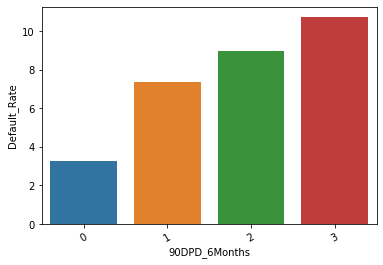

In [146]:
univariante_analysis(Master,Master['90DPD_6Months'])

###### Analysis of Impact of 90DPD_6Months:-  
 - The default rate of people with `90DPD_6Months` as 3 is highest but number of applicant in for that group is quite low. hence it is difficult to make any inference from it.
 - The Default rate increases with increase of Number of times 90 DPD or worse in last 6 months 

There seems to be `significant` relation between `Default Rate` and `90DPD_6Months` of Applicant

##### b.No of times 60 DPD or worse in last 6 months<a id="2.3b"></a>

In [147]:
Master['60DPD_6Months'].value_counts()

0    50779
1    11097
2     4891
3     1458
4      401
5       70
Name: 60DPD_6Months, dtype: int64

   60DPD_6Months  count_defaulters  No_of_Applicants  Default_Rate
0              0            1536.0             50779          3.02
1              1             781.0             11097          7.04
2              2             387.0              4891          7.91
3              3             145.0              1458          9.95
4              4              39.0               401          9.73
5              5               6.0                70          8.57


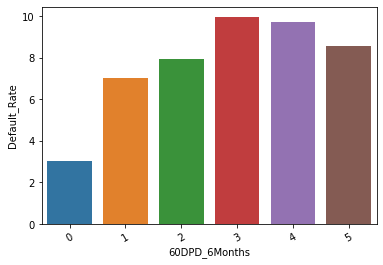

In [148]:
univariante_analysis(Master,Master['60DPD_6Months'])

###### Analysis of Impact of 60DPD_6Months:-  
 - The default rate of people with `60DPD_6Months` as 4 & 5 is fairly high but number of applicant in for that group is quite low. hence it is difficult to make any inference from it.
 - From Bar Chart, it seems that The Default rate increases with increase in Number of times 60 DPD or worse in last 6 months 

There seems to be `significant` relation between `Default Rate` and `60DPD_6Months` of Applicant

##### c.No of times 30 DPD or worse in last 6 months<a id="2.3c"></a>

In [149]:
Master['30DPD_6Months'].value_counts()

0    49009
1     9474
2     5878
3     2816
4     1034
5      375
6       95
7       15
Name: 30DPD_6Months, dtype: int64

   30DPD_6Months  count_defaulters  No_of_Applicants  Default_Rate
0              0            1409.0             49009          2.87
1              1             622.0              9474          6.57
2              2             463.0              5878          7.88
3              3             244.0              2816          8.66
4              4             104.0              1034         10.06
5              5              43.0               375         11.47
6              6               8.0                95          8.42
7              7               1.0                15          6.67


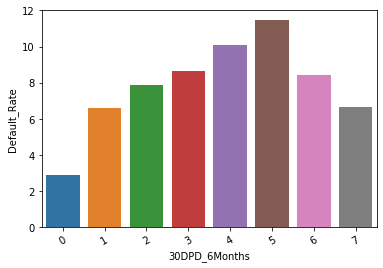

In [150]:
univariante_analysis(Master,Master['30DPD_6Months'])

###### Analysis of Impact of 30DPD_6Months:-  
 - The default rate of people with `30DPD_6Months` as 5,6 & 7 is fairly high but number of applicant in for that group is quite low. hence it is difficult to make any inference from it.
 - From Bar Chart, it seems that The Default rate increases with increase in  Number of times 30 DPD or worse in last 6 months 

There seems to be `significant` relation between `Default Rate` and `30DPD_6Months` of Applicant

##### d.No of times 90 DPD or worse in last 12 months<a id="2.3d"></a>

In [151]:
Master['90DPD_12Months'].value_counts()

0    49402
1    11627
2     6136
3     1234
4      262
5       35
Name: 90DPD_12Months, dtype: int64

   90DPD_12Months  count_defaulters  No_of_Applicants  Default_Rate
0               0            1464.0             49402          2.96
1               1             794.0             11627          6.83
2               2             486.0              6136          7.92
3               3             118.0              1234          9.56
4               4              27.0               262         10.31
5               5               5.0                35         14.29


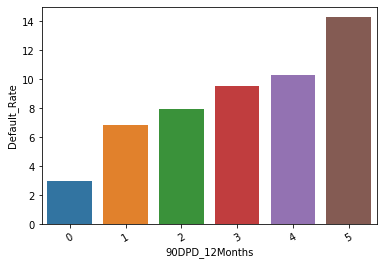

In [152]:
univariante_analysis(Master,Master['90DPD_12Months'])

###### Analysis of Impact of 90DPD_12Months:-  
 - The default rate of people with `90DPD_12Months` as 5,6 & 7 is fairly high but number of applicant in for that group is quite low. hence it is difficult to make any inference from it.
 - From Bar Chart, it seems that The Default rate increases with increase in Number of times 90 DPD or worse in last 12 months 

There seems to be `significant` relation between `Default Rate` and `90DPD_12Months` of Applicant

##### e.No of times 60 DPD or worse in last 12 months<a id="2.3e"></a>

In [153]:
Master['60DPD_12Months'].value_counts()

0    44875
1    12696
2     6400
3     3182
4     1037
5      389
6      110
7        7
Name: 60DPD_12Months, dtype: int64

   60DPD_12Months  count_defaulters  No_of_Applicants  Default_Rate
0               0            1337.0             44875          2.98
1               1             657.0             12696          5.17
2               2             481.0              6400          7.52
3               3             271.0              3182          8.52
4               4             100.0              1037          9.64
5               5              35.0               389          9.00
6               6              13.0               110         11.82
7               7               0.0                 7          0.00


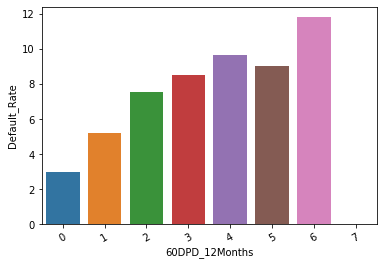

In [154]:
univariante_analysis(Master,Master['60DPD_12Months'])

###### Analysis of Impact of 60DPD_12Months:-  
  - From Bar Chart, it seems that The Default rate increases with increase in  Number of times 60 DPD or worse in last 12 months 

There seems to be `significant` relation between `Default Rate` and `60DPD_12Months` of Applicant

##### f.No of times 30 DPD or worse in last 12 months<a id="2.3f"></a>

In [155]:
Master['30DPD_12Months'].value_counts()

0    43866
1    11360
2     6096
3     4123
4     1913
5      842
6      366
7      106
8       23
9        1
Name: 30DPD_12Months, dtype: int64

   30DPD_12Months  count_defaulters  No_of_Applicants  Default_Rate
0               0            1274.0             43866          2.90
1               1             514.0             11360          4.52
2               2             450.0              6096          7.38
3               3             347.0              4123          8.42
4               4             172.0              1913          8.99
5               5              86.0               842         10.21
6               6              38.0               366         10.38
7               7              11.0               106         10.38
8               8               2.0                23          8.70
9               9               0.0                 1          0.00


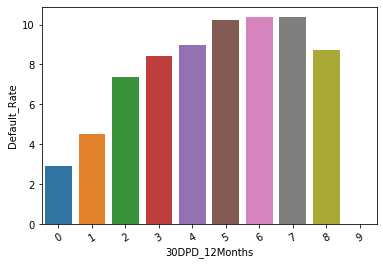

In [156]:
univariante_analysis(Master,Master['30DPD_12Months'])

###### Analysis of Impact of 30DPD_12Months:-  
  - From Bar Chart, it seems that The Default rate increases with increase in Number of times 30 DPD or worse in last 12 months 

There seems to be `significant` relation between `Default Rate` and `30DPD_12Months` of Applicant

##### g.Avgas CC Utilization in last 12 months<a id="2.3g"></a>

In [157]:
Master[Master['Avgas_Utilization_12Months']>100]

,Application ID,90DPD_6Months,60DPD_6Months,30DPD_6Months,90DPD_12Months,60DPD_12Months,30DPD_12Months,Avgas_Utilization_12Months,Trades_6Months,Trades_12Months,...,Age,Gender,Marital Status,No of dependents,Income,Education,Profession,Type of residence,Months_Current_Residence,Months_Current_Company
40003,738449145,0,0,0,0,0,0,113.0,3.0,7,...,50,M,Married,2.0,30.0,Phd,SE_PROF,Rented,6,22
40005,580811761,0,0,0,0,0,0,113.0,1.0,4,...,39,F,Married,2.0,28.0,Masters,SE,Rented,6,39
40006,468901168,1,1,1,1,1,1,113.0,1.0,4,...,37,M,Married,1.0,15.0,Bachelor,SE,Owned,98,46
40008,42796133,0,0,0,0,0,0,111.0,1.0,3,...,57,M,Married,4.0,28.0,Masters,SE,Owned,123,13
40010,454080217,0,0,0,0,0,0,113.0,2.0,5,...,42,M,Single,5.0,22.0,Masters,SAL,Rented,92,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46994,914866309,1,1,1,1,1,1,113.0,2.0,5,...,49,M,Married,3.0,39.0,Bachelor,SE_PROF,Owned,6,48
46996,763383837,0,0,0,0,0,0,113.0,3.0,5,...,49,M,Married,5.0,37.0,Masters,SAL,Rented,21,9
46997,835699698,0,0,0,0,0,0,113.0,2.0,3,...,44,M,Married,4.0,25.0,Masters,SAL,Rented,46,3
46999,417202564,0,0,0,0,0,0,113.0,1.0,4,...,28,M,Married,2.0,14.0,Masters,SE_PROF,Rented,61,16


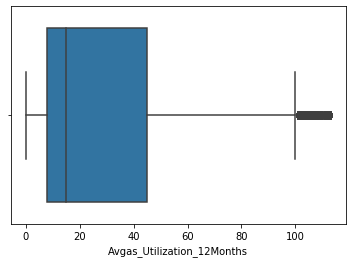

In [158]:
sns.boxplot(x='Avgas_Utilization_12Months', data=Master)
plt.show()

In [159]:
# Since there are a fair few data entries with Avgas_Utilization_12Months > 100, we will club all of those  at 40 
#Master['Avgas_Utilization_12Months'][Master['Avgas_Utilization_12Months']>100] =40

In [160]:
# To understand the behaviour of people with Avgas_Utilization, we are going to bucket the Avgas_Utilization groups into brackets of 10 and 
# study the response rates

bins = np.arange(10,Master['Avgas_Utilization_12Months'].max() + 10, 10)
Master['Avgas_Util_12Months_bins'] = pd.cut(Master['Avgas_Utilization_12Months'], bins, include_lowest=True)

   Avgas_Util_12Months_bins  count_defaulters  No_of_Applicants  Default_Rate
0             (9.999, 20.0]             560.0             18851          2.97
1              (20.0, 30.0]             301.0              4936          6.10
2              (30.0, 40.0]             286.0              4217          6.78
3              (40.0, 50.0]             378.0              4900          7.71
4              (50.0, 60.0]             285.0              4116          6.92
5              (60.0, 70.0]             226.0              3098          7.30
6              (70.0, 80.0]             158.0              2016          7.84
7              (80.0, 90.0]              76.0              1113          6.83
8             (90.0, 100.0]              31.0               533          5.82
9            (100.0, 110.0]              23.0               415          5.54
10           (110.0, 120.0]             154.0              3196          4.82


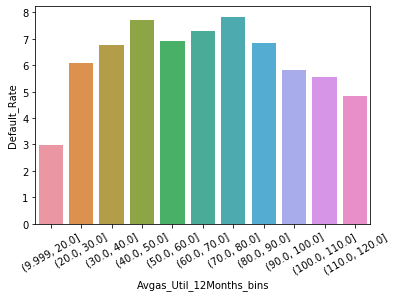

In [161]:
univariante_analysis(Master,Master['Avgas_Util_12Months_bins'])

###### Analysis of Impact of Avgas_Utilization_12Months:-  
  -  The Default rate is highest for Applicants with Avgas Utilization value between 70-80 followed by Applicants with Avgas Utilization value between 60-70 
  
There seems to be `no significant` relation between `Default Rate` and `Avgas_Utilization_12Months` of Applicant

##### h.No of trades opened in last 6 months<a id="2.3h"></a>

In [162]:
Master['Trades_6Months'].value_counts()

1.0     20065
2.0     12080
0.0     11186
3.0      9380
4.0      6274
5.0      3649
6.0      2331
7.0      1648
8.0      1153
9.0       616
10.0      238
11.0       65
12.0       11
Name: Trades_6Months, dtype: int64

    Trades_6Months  count_defaulters  No_of_Applicants  Default_Rate
0              0.0             229.0             11186          2.05
1              1.0             534.0             20065          2.66
2              2.0             637.0             12080          5.27
3              3.0             596.0              9380          6.35
4              4.0             433.0              6274          6.90
5              5.0             210.0              3649          5.76
6              6.0             108.0              2331          4.63
7              7.0              65.0              1648          3.94
8              8.0              52.0              1153          4.51
9              9.0              21.0               616          3.41
10            10.0               7.0               238          2.94
11            11.0               2.0                65          3.08
12            12.0               0.0                11          0.00


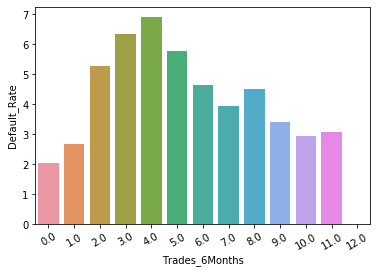

In [163]:
univariante_analysis(Master,Master['Trades_6Months'])

###### Analysis of Impact of Trades_6Months:-  
  - From Bar Chart, it seems that The Default rate is highest for Number of Trades as 4 followed by number of trades as 3 and number of trades as 5 

There seems to be `significant` relation between `Default Rate` and `Trades_6Months` of Applicant

##### i.No of trades opened in last 12 months<a id="2.3i"></a>

In [164]:
Master['Trades_12Months'].value_counts()

1     11360
2      9302
4      4838
3      4659
5      4534
6      4188
7      4080
0      3960
8      3791
9      3363
10     2803
11     2171
12     1697
13     1364
14     1113
15     1067
16      991
17      860
18      735
19      612
20      433
21      308
22      218
23      120
24       72
25       34
26       11
27        9
28        3
Name: Trades_12Months, dtype: int64

    Trades_12Months  count_defaulters  No_of_Applicants  Default_Rate
0                 0              69.0              3960          1.74
1                 1             178.0             11360          1.57
2                 2             178.0              9302          1.91
3                 3             197.0              4659          4.23
4                 4             208.0              4838          4.30
5                 5             232.0              4534          5.12
6                 6             266.0              4188          6.35
7                 7             267.0              4080          6.54
8                 8             305.0              3791          8.05
9                 9             213.0              3363          6.33
10               10             197.0              2803          7.03
11               11             134.0              2171          6.17
12               12             114.0              1697          6.72
13               13 

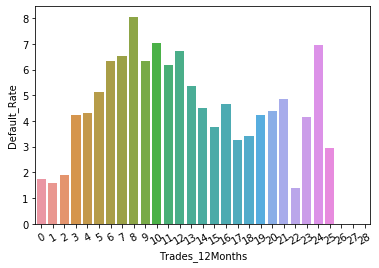

In [165]:
univariante_analysis(Master,Master['Trades_12Months'])

###### Analysis of Impact of Trades_12Months:-  
  - From Bar Chart, it seems that The Default rate is highest for Number of Trades as 8 followed by number of trades as 10 

There seems to be ` no significant` relation between `Default Rate` and `Trades_12Months` of Applicant

##### j.No of PL trades opened in last 6 months<a id="2.3j"></a>

In [166]:
Master['PL_Trades_6Months'].value_counts()

0    30029
1    13505
2    12527
3     7921
4     3332
5     1087
6      295
Name: PL_Trades_6Months, dtype: int64

   PL_Trades_6Months  count_defaulters  No_of_Applicants  Default_Rate
0                  0             656.0             30029          2.18
1                  1             689.0             13505          5.10
2                  2             801.0             12527          6.39
3                  3             497.0              7921          6.27
4                  4             195.0              3332          5.85
5                  5              48.0              1087          4.42
6                  6               8.0               295          2.71


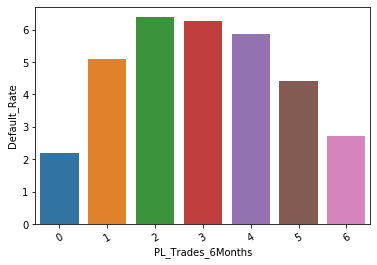

In [167]:
univariante_analysis(Master,Master['PL_Trades_6Months'])

###### Analysis of Impact of PL_Trades_6Months:-  
  - From Bar Chart, it seems that The Default rate is highest for PL_Trades_6Months as 2 followed by PL_Trades_6Months as 3 

There seems to be `significant` relation between `Default Rate` and `PL_Trades_6Months` of Applicant

##### k.No of PL trades opened in last 12 months<a id="2.3k"></a>

In [168]:
Master['PL_Trades_12Months'].value_counts()

0     24787
3      8104
4      7879
2      6810
1      6625
5      6167
6      4007
7      2217
8      1172
9       599
10      253
11       66
12       10
Name: PL_Trades_12Months, dtype: int64

    PL_Trades_12Months  count_defaulters  No_of_Applicants  Default_Rate
0                    0             415.0             24787          1.67
1                    1             247.0              6625          3.73
2                    2             365.0              6810          5.36
3                    3             506.0              8104          6.24
4                    4             534.0              7879          6.78
5                    5             387.0              6167          6.28
6                    6             240.0              4007          5.99
7                    7             108.0              2217          4.87
8                    8              50.0              1172          4.27
9                    9              28.0               599          4.67
10                  10              10.0               253          3.95
11                  11               3.0                66          4.55
12                  12               1.0           

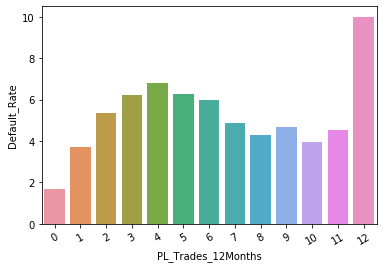

In [169]:
univariante_analysis(Master,Master['PL_Trades_12Months'])

###### Analysis of Impact of PL_Trades_12Months:-  
  - The Default rate is highest for PL_Trades_12Months as 12 but the bumber of applicant in that group is low. hence it is difficult to make inference from it 
  - From Bar Chart, it seems that The Default rate is highest for PL_Trades_12Months as 4 followed by PL_Trades_12Months as 5 

There seems to be `significant` relation between `Default Rate` and `PL_Trades_12Months` of Applicant

##### l.No of Inquiries in last 6 months`<a id="2.3l"></a>

In [170]:
Master['Enquires_6Months'].value_counts()

0     24074
1     13102
2     12783
3      7230
4      4234
5      3015
6      1745
7      1146
8       834
9       425
10      108
Name: Enquires_6Months, dtype: int64

    Enquires_6Months  count_defaulters  No_of_Applicants  Default_Rate
0                  0             487.0             24074          2.02
1                  1             655.0             13102          5.00
2                  2             661.0             12783          5.17
3                  3             512.0              7230          7.08
4                  4             269.0              4234          6.35
5                  5             150.0              3015          4.98
6                  6              72.0              1745          4.13
7                  7              40.0              1146          3.49
8                  8              33.0               834          3.96
9                  9              13.0               425          3.06
10                10               2.0               108          1.85


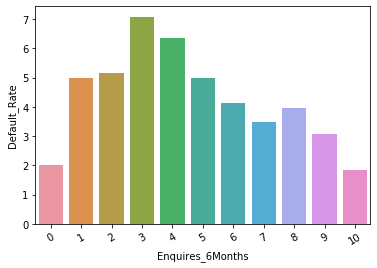

In [171]:
univariante_analysis(Master,Master['Enquires_6Months'])

###### Analysis of Impact of Enquires_6Months:-  
  - From Bar Chart, it seems that The Default rate is highest for Enquires_6Months as 3 followed by Enquires_6Months as 4 

There seems to be `significant` relation between `Default Rate` and `Enquires_6Months` of Applicant

##### m.No of Inquiries in last 12 months<a id="2.3m"></a>

In [172]:
Master['Enquires_12Months'].value_counts()

0     19927
3      8931
2      7864
4      7085
5      4901
6      3604
1      3561
7      2983
8      2339
9      1777
10     1507
11     1228
12      934
13      789
14      549
15      360
16      212
17       97
18       40
19        6
20        2
Name: Enquires_12Months, dtype: int64

    Enquires_12Months  count_defaulters  No_of_Applicants  Default_Rate
0                   0             275.0             19927          1.38
1                   1             147.0              3561          4.13
2                   2             380.0              7864          4.83
3                   3             441.0              8931          4.94
4                   4             379.0              7085          5.35
5                   5             356.0              4901          7.26
6                   6             246.0              3604          6.83
7                   7             209.0              2983          7.01
8                   8             141.0              2339          6.03
9                   9              71.0              1777          4.00
10                 10              83.0              1507          5.51
11                 11              53.0              1228          4.32
12                 12              40.0               934       

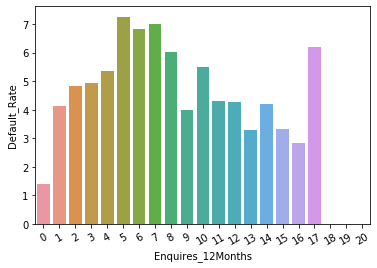

In [173]:
univariante_analysis(Master,Master['Enquires_12Months'])

###### Analysis of Impact of Enquires_12Months:-  
  - From Bar Chart, it seems that The Default rate is highest for Enquires_12Months as 5 followed by Enquires_6Months as 7 

There seems to be `significant` relation between `Default Rate` and `Enquires_12Months` of Applicant

##### n.Presence of open home loan<a id="2.3n"></a>

In [174]:
Master['Home_Loan_Present'].value_counts()

0.0    50667
1.0    18029
Name: Home_Loan_Present, dtype: int64

   Home_Loan_Present  count_defaulters  No_of_Applicants  Default_Rate
0                0.0            2289.0             50667          4.52
1                1.0             605.0             18029          3.36


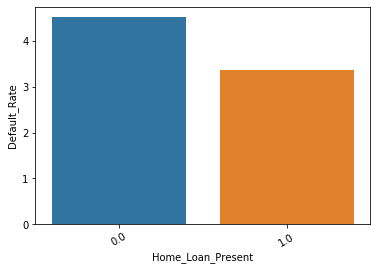

In [175]:
univariante_analysis(Master,Master['Home_Loan_Present'])

###### Analysis of Impact of Home_Loan_Present:-  
  - From Bar Chart, it seems that The Default rate of applicant with having home loan is lower compared to applicant not having home loan

There seems to be `significant` relation between `Default Rate` and `Home_Loan_Present` of Applicant

##### o.Outstanding Balance<a id="2.3o"></a>

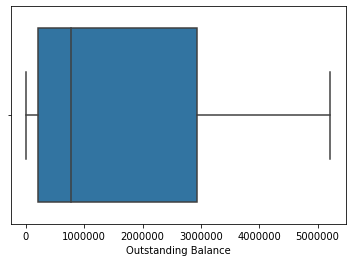

In [176]:
sns.boxplot(x='Outstanding Balance', data=Master)
plt.show()

In [177]:
# To understand the behaviour of people with Outstanding Balance, we are going to bucket the Outstanding Balance groups into brackets of 10 and 
# study the response rates

bins = np.arange(10,Master['Outstanding Balance'].max() + 10, 1000000)
Master['Outstanding Balance_bins'] = pd.cut(Master['Outstanding Balance'], bins, include_lowest=True)

  Outstanding Balance_bins  count_defaulters  No_of_Applicants  Default_Rate
0       (9.999, 1000010.0]            1809.0             42299          4.28
1   (1000010.0, 2000010.0]             475.0              8169          5.81
2   (2000010.0, 3000010.0]             133.0              8284          1.61
3   (3000010.0, 4000010.0]             406.0              8354          4.86
4   (4000010.0, 5000010.0]              67.0              1473          4.55


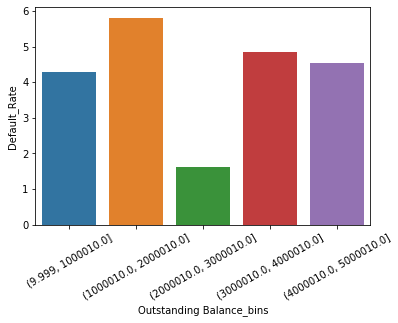

In [178]:
univariante_analysis(Master,Master['Outstanding Balance_bins'])

###### Analysis of Impact of Outstanding Balance:-  
  - From Bar Chart, it seems that The Default rate is highest for applicant having outsanding balance between 1million-2million followed by applicant having outsanding balance between 3million-4million
  
There seems to be `significant` relation between `Default Rate` and `Outstanding Balance` of Applicant

##### p.Total No of Trades<a id="2.3p"></a>

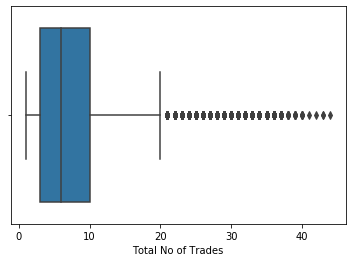

In [179]:
sns.boxplot(x='Total No of Trades', data=Master)
plt.show()

In [180]:
# To understand the behaviour of people with Total No of Trades, we are going to bucket the Total No of Trades groups into brackets of 10 and 
# study the response rates

bins = np.arange(10,Master['Total No of Trades'].max() + 10, 10)
Master['Total No of Trades_bins'] = pd.cut(Master['Total No of Trades'], bins, include_lowest=True)

  Total No of Trades_bins  count_defaulters  No_of_Applicants  Default_Rate
0           (9.999, 20.0]             777.0             12277          6.33
1            (20.0, 30.0]             232.0              5912          3.92
2            (30.0, 40.0]              37.0               895          4.13
3            (40.0, 50.0]               0.0                 5          0.00


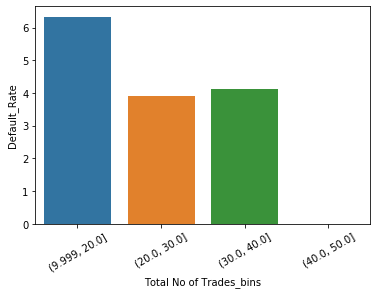

In [181]:
univariante_analysis(Master,Master['Total No of Trades_bins'])

###### Analysis of Impact of Total No of Trades:-  
  - From Bar Chart, it seems that The Default rate is highest for If total no of trades is low
  
There seems to be `significant` relation between `Default Rate` and `Total No of Trades` of Applicant

##### q.Presence of open auto loan<a id="2.3q"></a>

In [182]:
Master['Auto_Loan_Present'].value_counts()

0    62781
1     5915
Name: Auto_Loan_Present, dtype: int64

   Auto_Loan_Present  count_defaulters  No_of_Applicants  Default_Rate
0                  0            2675.0             62781          4.26
1                  1             219.0              5915          3.70


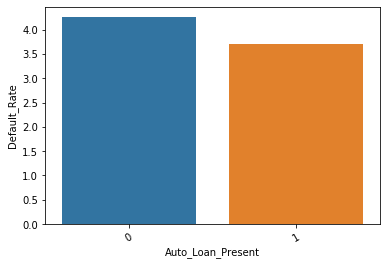

In [183]:
univariante_analysis(Master,Master['Auto_Loan_Present'])

###### Analysis of Impact of Auto_Loan_Present:-  
  - From Bar Chart, it seems that The Default rate of applicant with having auto loan is lower compared to applicant not having auto loan

There seems to be `significant` relation between `Default Rate` and `Auto_Loan_Present` of Applicant

### 2. Multivariante Analysis

##### Heatmap<a id="2.3r"></a>

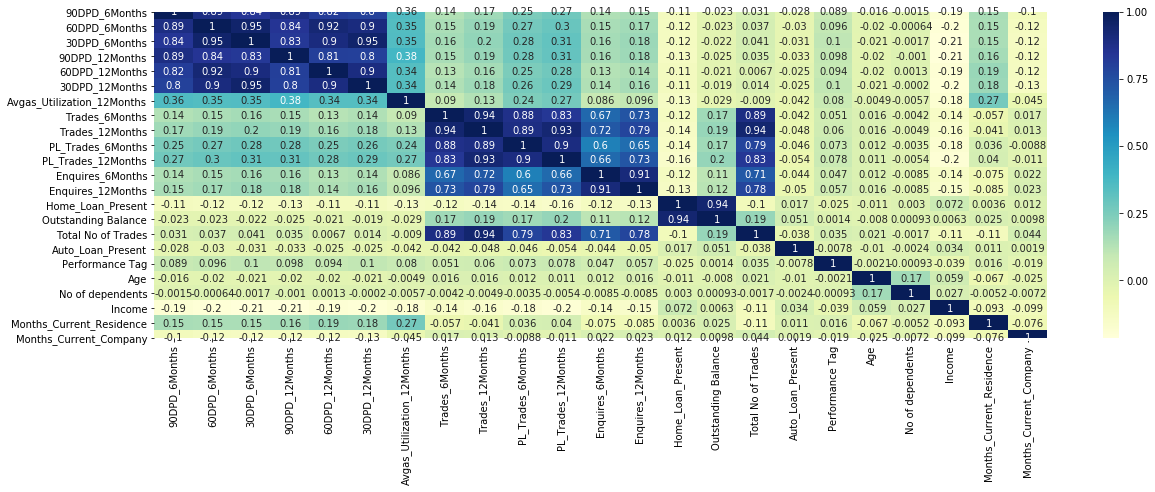

In [184]:
#Let us check if there is any correlation
plt.figure(figsize=(20, 6))
sns.heatmap(Master.drop(columns=['Application ID']).corr(), annot=True, cmap="YlGnBu")

##### Anlaysis

- The Variable `Age` have highest co relation with `Performance Tag`(Defaulter Rate) Followed by  `30DDPD_12Months` & `30DDPD_6Months`
- Variables related to `Trade` are highly co related to each other
- Similarly Variables related to `DPD` are also highly co related to each other

### Step 4 :-Building Model on Non-WOE Master Dataset<a id="2.4"></a>

### Step 4(a) :- Data Preparation<a id="2.41"></a>

##### a.Drop Unrequired column

In [185]:
# Droping unrequired column
Master.drop(columns = ['Application ID','Avgas_Util_12Months_bins','Outstanding Balance_bins','Total No of Trades_bins'], inplace = True)

In [186]:
# Create Columns having dummy variables

Categorical_variable=['90DPD_6Months', '60DPD_6Months', '30DPD_6Months','90DPD_12Months', '60DPD_12Months', '30DPD_12Months',
                      'Trades_6Months', 'Trades_12Months','PL_Trades_6Months', 'PL_Trades_12Months', 'Enquires_6Months',
                      'Enquires_12Months', 'Home_Loan_Present', 'Auto_Loan_Present','Gender',
                      'Marital Status','No of dependents','Education','Profession','Type of residence']

Dummy_Columns = pd.get_dummies(Master[Categorical_variable], drop_first = True)

In [187]:
# Add the dummy Columns to the original dataframe
Master = pd.concat([Master, Dummy_Columns], axis = 1)

In [188]:
# Drop Categorical as we have created the dummies for it
Master.drop(Categorical_variable, axis = 1, inplace = True)
Master.head()

,Avgas_Utilization_12Months,Outstanding Balance,Total No of Trades,Performance Tag,Age,Income,Months_Current_Residence,Months_Current_Company,Gender_M,Marital Status_Single,Education_Masters,Education_Others,Education_Phd,Education_Professional,Profession_SE,Profession_SE_PROF,Type of residence_Living with Parents,Type of residence_Others,Type of residence_Owned,Type of residence_Rented
0,4.0,2999395.0,4,0.0,48,40.0,113,56,0,0,0,0,0,0,0,0,0,0,0,1
1,3.0,3078.0,5,0.0,31,55.0,112,46,1,0,0,0,0,1,0,1,0,0,0,1
2,7.0,3004972.0,2,0.0,32,46.0,104,49,1,1,0,0,0,0,0,1,0,0,0,1
3,11.0,3355373.0,4,0.0,43,53.0,94,53,1,0,0,0,0,0,1,0,0,0,0,1
4,12.0,3014283.0,4,0.0,35,44.0,112,43,0,0,0,0,0,1,0,0,0,0,0,1


### Step 4(b) :- Test Train Split<a id="2.42"></a>

In [189]:
# Putting feature variable to X
X = Master.drop(['Performance Tag'],axis=1)

# Putting response variable to y
y = Master['Performance Tag']

In [190]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

### Step 4(c) :- Standardisation<a id="2.43"></a>

In [191]:
# Create list of numerical variables
num_vars = ['Avgas_Utilization_12Months','Outstanding Balance','Total No of Trades','Age','Income',
            'Months_Current_Residence','Months_Current_Company']

In [192]:
# Apply scaler() to all the columns in `X_train`
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_train.head()

,Avgas_Utilization_12Months,Outstanding Balance,Total No of Trades,Age,Income,Months_Current_Residence,Months_Current_Company,Gender_M,Marital Status_Single,Education_Masters,Education_Others,Education_Phd,Education_Professional,Profession_SE,Profession_SE_PROF,Type of residence_Living with Parents,Type of residence_Others,Type of residence_Owned,Type of residence_Rented
59711,0.557522,0.646509,0.209302,0.823529,0.504132,0.958333,0.076923,1,0,0,0,0,1,1,0,0,0,0,1
54337,0.247788,0.648529,0.116279,0.911765,0.206612,0.041667,0.415385,1,1,0,0,0,1,0,1,0,0,0,1
1051,0.026549,0.003051,0.046512,0.455882,0.818182,0.733333,0.130769,0,0,0,0,0,1,0,0,0,0,0,1
65064,0.300885,0.120041,0.162791,0.955882,0.553719,0.141667,0.507692,1,0,1,0,0,0,0,0,0,0,0,1
45046,1.000000,0.140219,0.116279,0.985294,0.471074,0.216667,0.123077,1,0,0,0,0,0,0,0,0,0,1,0


In [193]:
# Apply scaler() to all the columns in `X_test`
X_test[num_vars] = scaler.fit_transform(X_test[num_vars])
X_test.head()

,Avgas_Utilization_12Months,Outstanding Balance,Total No of Trades,Age,Income,Months_Current_Residence,Months_Current_Company,Gender_M,Marital Status_Single,Education_Masters,Education_Others,Education_Phd,Education_Professional,Profession_SE,Profession_SE_PROF,Type of residence_Living with Parents,Type of residence_Others,Type of residence_Owned,Type of residence_Rented
8660,0.026549,0.589920,0.097561,0.692308,0.900826,0.000000,0.186992,0,1,0,0,0,0,1,0,0,0,0,1
55283,0.362832,0.120058,0.219512,0.769231,0.388430,0.483333,0.081301,1,0,1,0,0,0,0,1,0,0,0,1
32756,0.106195,0.845228,0.414634,0.584615,0.553719,0.000000,0.162602,1,0,1,0,0,0,0,1,0,0,0,1
68471,0.380531,0.108235,0.097561,0.753846,0.603306,0.200000,0.544715,1,0,1,0,0,0,0,1,0,0,0,1
7225,0.106195,0.591375,0.097561,0.815385,0.553719,0.775000,0.357724,1,0,0,0,0,0,0,0,0,0,0,1


### Step 4(d) :- Building Model <a id="2.44"></a>

 **Model 1** - `Building Logistic Model on Non-WOE Master Datset`

##### Model 1 - Lets Build with top 15 variables

In [194]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 15)
rfe = rfe.fit(X_train, y_train)

In [195]:
col = X_train.columns[rfe.support_]
print(col)
X_train_rfe=X_train[col]

Index(['Avgas_Utilization_12Months', 'Outstanding Balance',
       'Total No of Trades', 'Age', 'Income', 'Months_Current_Residence',
       'Months_Current_Company', 'Marital Status_Single', 'Education_Others',
       'Education_Professional', 'Profession_SE',
       'Type of residence_Living with Parents', 'Type of residence_Others',
       'Type of residence_Owned', 'Type of residence_Rented'],
      dtype='object')


##### 1. Make model with top 15 rfe variables

In [196]:
#Making model with top rfe variables
X_train_rfe, lm_rfe , highest_pvalue_variable= get_model_and_print_summary(X_train_rfe)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                48087
Model:                            GLM   Df Residuals:                    48071
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8175.8
Date:                Mon, 16 Dec 2019   Deviance:                       16352.
Time:                        21:15:59   Pearson chi2:                 4.71e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

##### 2. Rebuild model after dropping `Marital Status_Single`

In [197]:
#drop column having higher p value and rebuild the model again
X_train_rfe, lm_rfe,highest_pvalue_variable = get_model_and_print_summary(X_train_rfe.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                48087
Model:                            GLM   Df Residuals:                    48072
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8175.9
Date:                Mon, 16 Dec 2019   Deviance:                       16352.
Time:                        21:16:00   Pearson chi2:                 4.71e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

##### 3. Rebuild model after dropping `Type of residence_Owned`

In [198]:
#drop column having higher p value and rebuild the model again
X_train_rfe, lm_rfe,highest_pvalue_variable = get_model_and_print_summary(X_train_rfe.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                48087
Model:                            GLM   Df Residuals:                    48073
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8176.1
Date:                Mon, 16 Dec 2019   Deviance:                       16352.
Time:                        21:16:00   Pearson chi2:                 4.71e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

##### 4. Rebuild model after dropping `Age`

In [199]:
#drop column having higher p value and rebuild the model again
X_train_rfe, lm_rfe,highest_pvalue_variable = get_model_and_print_summary(X_train_rfe.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                48087
Model:                            GLM   Df Residuals:                    48074
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8176.4
Date:                Mon, 16 Dec 2019   Deviance:                       16353.
Time:                        21:16:01   Pearson chi2:                 4.70e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

##### 5. Rebuild model after dropping `Type of residence_Others`

In [200]:
#drop column having higher p value and rebuild the model again
X_train_rfe, lm_rfe,highest_pvalue_variable = get_model_and_print_summary(X_train_rfe.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                48087
Model:                            GLM   Df Residuals:                    48075
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8176.9
Date:                Mon, 16 Dec 2019   Deviance:                       16354.
Time:                        21:16:01   Pearson chi2:                 4.70e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

##### 6. Rebuild model after dropping `Outstanding Balance`

In [201]:
#drop column having higher p value and rebuild the model again
X_train_rfe, lm_rfe,highest_pvalue_variable = get_model_and_print_summary(X_train_rfe.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                48087
Model:                            GLM   Df Residuals:                    48076
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8177.4
Date:                Mon, 16 Dec 2019   Deviance:                       16355.
Time:                        21:16:02   Pearson chi2:                 4.70e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

##### 7. Rebuild model after dropping `Education_Others`

In [202]:
#drop column having higher p value and rebuild the model again
X_train_rfe, lm_rfe,highest_pvalue_variable = get_model_and_print_summary(X_train_rfe.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                48087
Model:                            GLM   Df Residuals:                    48077
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8178.1
Date:                Mon, 16 Dec 2019   Deviance:                       16356.
Time:                        21:16:03   Pearson chi2:                 4.70e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

##### 8. Rebuild model after dropping `Type of residence_Living with Parents`

In [203]:
#drop column having higher p value and rebuild the model again
X_train_rfe, lm_rfe,highest_pvalue_variable = get_model_and_print_summary(X_train_rfe.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                48087
Model:                            GLM   Df Residuals:                    48078
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8179.1
Date:                Mon, 16 Dec 2019   Deviance:                       16358.
Time:                        21:16:06   Pearson chi2:                 4.70e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

##### 9. Rebuild model after dropping `Type of residence_Rented`

In [204]:
#drop column having higher p value and rebuild the model again
X_train_rfe, lm_rfe,highest_pvalue_variable = get_model_and_print_summary(X_train_rfe.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                48087
Model:                            GLM   Df Residuals:                    48079
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8179.8
Date:                Mon, 16 Dec 2019   Deviance:                       16360.
Time:                        21:16:07   Pearson chi2:                 4.70e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

##### 10. Rebuild model after dropping `Education_Professional`

In [205]:
#drop column having higher p value and rebuild the model again
X_train_rfe, lm_rfe,highest_pvalue_variable = get_model_and_print_summary(X_train_rfe.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                48087
Model:                            GLM   Df Residuals:                    48080
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8180.7
Date:                Mon, 16 Dec 2019   Deviance:                       16361.
Time:                        21:16:10   Pearson chi2:                 4.70e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

##### 11. Rebuild model after dropping `Profession_SE`

In [206]:
#drop column having higher p value and rebuild the model again
X_train_rfe, lm_rfe,highest_pvalue_variable = get_model_and_print_summary(X_train_rfe.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                48087
Model:                            GLM   Df Residuals:                    48081
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8181.6
Date:                Mon, 16 Dec 2019   Deviance:                       16363.
Time:                        21:16:11   Pearson chi2:                 4.70e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

##### 12. Rebuild model after dropping `Months_Current_Residence`

In [207]:
#drop column having higher p value and rebuild the model again
X_train_rfe, lm_rfe,highest_pvalue_variable = get_model_and_print_summary(X_train_rfe.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                48087
Model:                            GLM   Df Residuals:                    48082
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8182.9
Date:                Mon, 16 Dec 2019   Deviance:                       16366.
Time:                        21:16:11   Pearson chi2:                 4.71e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [208]:
#Lets check ViF scores
get_vif(X_train_rfe)

                     Features    VIF
0                       const  10.73
3                      Income   1.06
1  Avgas_Utilization_12Months   1.04
2          Total No of Trades   1.01
4      Months_Current_Company   1.01


**All variables have a good value of VIF. So we need not drop any more variables and we can proceed with making predictions using this model only**

In [209]:
X_train_final = X_train_rfe
lm_final = lm_rfe

##### i . Analyzing top predictors

In [210]:
top_predictor_variables=list(X_train_final.columns)
top_predictor_variables.remove('const')
print('The Top Predictors are :-')
top_predictor_variables

The Top Predictors are :-


['Avgas_Utilization_12Months',
 'Total No of Trades',
 'Income',
 'Months_Current_Company']

#### ii.  Draw ROC Curve

In [211]:
#Let's create a dataframe with lead score and converted values.
y_train_final = pd.DataFrame({'predicted_response':y_train.values, 'probablity_predicted_response':lm_final.predict(X_train_final)})
y_train_final.head()

,predicted_response,probablity_predicted_response
59711,0.0,0.063032
54337,0.0,0.035891
1051,0.0,0.023145
65064,0.0,0.031841
45046,0.0,0.093706


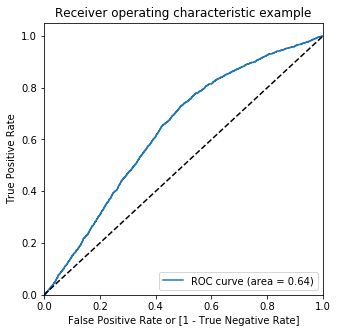

In [212]:
fpr, tpr, thresholds = roc_curve(y_train_final.predicted_response,y_train_final.probablity_predicted_response, drop_intermediate=False )
draw_roc(y_train_final.predicted_response, y_train_final.probablity_predicted_response)

#### iii.  Obtain Optimum Cutoff between sensitivity , specificity & Accuracy

In [213]:
numbers = [round(x * 0.05, 2) for x in range(0, 20)]
y_train_pred_final = y_train_final

for i in numbers:
    y_train_pred_final[i]= y_train_final.probablity_predicted_response.map(lambda x: 1 if x > i else 0)

y_train_pred_final.head()

,predicted_response,probablity_predicted_response,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,...,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95
59711,0.0,0.063032,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
54337,0.0,0.035891,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1051,0.0,0.023145,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65064,0.0,0.031841,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45046,0.0,0.093706,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [214]:
#Lets create cut off dataframe having accuracy sensitivity & specificity
cutoff_df= create_cutoff_df(y_train_pred_final)
cutoff_df.head()

,Accuracy,Sensitivity,Specificity
0.00,0.041966,1.000000,0.000000
0.05,0.705950,0.445986,0.717337
0.10,0.950569,0.008424,0.991838
0.15,0.958034,0.000000,1.000000
0.20,0.958034,0.000000,1.000000


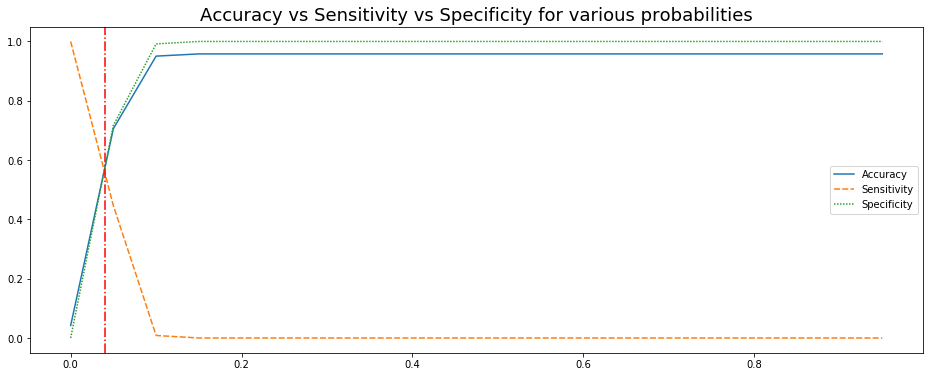

In [215]:
#Visualize accuracy, sensitivity and specificity graph
accuracy_sensitivity_specificty_graph(cutoff_df,0.04)

Graph Analysis :-  
`ROC curve shows that 0.04 is the optimum point to take it as a cutoff probability`

#### iv.Precision and Recall TradeOff

In [216]:
# p, r, thresholds = precision_recall_curve(y_train_final.predicted_response, y_train_final.probablity_predicted_response)

# cutoff_df = pd.DataFrame({'Precision': pd.Series(p[:-1], index=thresholds),
#               'Recall':pd.Series(r[:-1], index=thresholds)})
# cutoff_df

# plt.figure(figsize=(16, 6))
# sns.lineplot(data=cutoff_df)
# plt.title('Precision vs Recall for various probabilities', fontsize=18)
# plt.axhline(0.47, color='b', linestyle='-.')
# plt.axvline(0.25, color='r', linestyle='-.')

The optimum value from Precision and Recall is `0.25`

In [217]:
# cutoff_probability1 = 0.034
# predicted_1 = y_train_predicted_final.converted_probability.map( lambda x: 1 if x > cutoff_probability1 else 0)
# metrics_dataframe(y_train_predicted_final.converted, predicted_1)

In [218]:
# cutoff_probability2 = 0.25
# predicted_2 = y_train_predicted_final.converted_probability.map( lambda x: 1 if x > cutoff_probability2 else 0)
# metrics_dataframe(y_train_predicted_final.converted, predicted_2)

In [219]:
cutoff_probability = 0.04
predicted_final = y_train_pred_final.probablity_predicted_response.map( lambda x: 1 if x > cutoff_probability else 0)
Master_LR_Non_Woe=metrics_dataframe(y_train_final.predicted_response, predicted_final)
Master_LR_Non_Woe

Confusion Matrix is :-
[[25429 20640]
 [  657  1361]]
Metrics and their score for above confusion metris :-


,Metric,Score
0,Sensitivity/Recall,0.674430
1,Specificity,0.551976
2,Accuracy,0.557115
3,Precision,0.061861
4,False Positive Rate,0.448024
5,Positive Predictive Value,0.061861
6,Negative Predictive Value,0.974814


###### Analysis of Metrics of Logistic Regression on Non Woe Master Dataset:-  
   - `Specificity` & `Accuracy` of `Logistic Regression` is around `55%` which is quite low
   - But `Sensitivity/Recall` of `Logistic Regression` is `67%` which is also quite low

Lets Make model with Random Forest

**Model 2** - `Building Random Forest Model on NON WOE Master Datset`

##### A. Create Random Forest

In [220]:
#Create Random Forest
rfc = RandomForestClassifier(class_weight ='balanced', n_jobs = -1)
rfc.fit(X_train, y_train)

#make predictions
y_predicted = rfc.predict(X_test)

#check metrics
print(classification_report(y_test, y_predicted))
metrics_dataframe(y_test, y_predicted)

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     19733
         1.0       0.00      0.00      0.00       876

    accuracy                           0.96     20609
   macro avg       0.48      0.50      0.49     20609
weighted avg       0.92      0.96      0.94     20609

Confusion Matrix is :-
[[19733     0]
 [  876     0]]
Metrics and their score for above confusion metris :-


,Metric,Score
0,Sensitivity/Recall,0.000000
1,Specificity,1.000000
2,Accuracy,0.957494
3,Precision,NaN
4,False Positive Rate,0.000000
5,Positive Predictive Value,NaN
6,Negative Predictive Value,0.957494


#### B. Hyper Parameter Tuning

In [221]:
param_grid = {
    'max_depth': [2, 4, 8],
    'min_samples_leaf': range(10, 50, 10),
    'min_samples_split': range(10, 50, 10),
    'n_estimators': [10, 30, 50]
}

rfc = GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced'),
                        param_grid=param_grid,
                        scoring='recall',
                        cv=KFold(n_splits=3, shuffle=True, random_state=42),
                        n_jobs=-1,
                        verbose=1,
                        return_train_score=True) 
rfc.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  2.2min finished


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                             

In [222]:
print('Best Paramaters  :- ',rfc.best_params_)
print('Best Score  :- ',rfc.best_score_)
print('Best Estimators  :- ',rfc.best_estimator_)

Best Paramaters  :-  {'max_depth': 2, 'min_samples_leaf': 40, 'min_samples_split': 40, 'n_estimators': 10}
Best Score  :-  0.7289737420010374
Best Estimators  :-  RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=40,
                       min_samples_split=40, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)


##### C. Building Final Random Forest

In [223]:
rfc_final = RandomForestClassifier(bootstrap=True, class_weight='balanced',criterion='gini',
                       max_depth=rfc.best_estimator_.max_depth, 
                       max_features=rfc.best_estimator_.max_features,
                       min_samples_leaf=rfc.best_estimator_.min_samples_leaf,
                       min_samples_split=rfc.best_estimator_.min_samples_split,
                       n_estimators=rfc.best_estimator_.n_estimators,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_weight_fraction_leaf=0.0,
                        n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

rfc_final.fit(X_train, y_train)
y_predicted = rfc_final.predict(X_test)

In [224]:
print(classification_report(y_test, y_predicted))
Master_RF_Non_Woe=metrics_dataframe(y_test, y_predicted)
Master_RF_Non_Woe

              precision    recall  f1-score   support

         0.0       0.98      0.55      0.71     19733
         1.0       0.07      0.71      0.12       876

    accuracy                           0.56     20609
   macro avg       0.52      0.63      0.41     20609
weighted avg       0.94      0.56      0.68     20609

Confusion Matrix is :-
[[10918  8815]
 [  257   619]]
Metrics and their score for above confusion metris :-


,Metric,Score
0,Sensitivity/Recall,0.706621
1,Specificity,0.553286
2,Accuracy,0.559804
3,Precision,0.065614
4,False Positive Rate,0.446714
5,Positive Predictive Value,0.065614
6,Negative Predictive Value,0.977002


###### Analysis of Metrics of Random Forest for Non Woe Master Dataset :-  
   - `Specificity` & `Accuracy` of `Random Forest` is above `54%` which is quite low
   - But `Sensitivity/Recall` of `Random Forest` is `70%` which is quite good

### Step 5 :- Model Building on WOE Master Dataset<a id="2.5"></a>

### Step 5(a) :- Calculating Woe & IV value for Master Dataset <a id="2.51">

In [225]:
Master_Without_Imputation=Master_copy
## calculate woe and iv for Master data (without any imputation)
Master_IV, Master_WOE = calculate_WOE_IV(data = Master_Without_Imputation.drop(['Application ID'],axis=1), 
                                           target = 'Performance Tag', bins=8, show_woe = True)




Information value of 90DPD_6Months is 0.163307
        Variable  Cutoff  Number  Defaults  Defaults(%)  Non-Defaults  \
0  90DPD_6Months       0   54670    1794.0     0.608342       52876.0   
1  90DPD_6Months       1   13222     972.0     0.329603       12250.0   
2  90DPD_6Months       2    1776     160.0     0.054256        1616.0   
3  90DPD_6Months       3     208      23.0     0.007799         185.0   

   Non-Defaults(%)       WOE        IV  
0         0.790055 -0.261365  0.047494  
1         0.183035  0.588211  0.086213  
2         0.024146  0.809601  0.024377  
3         0.002764  1.037275  0.005223  


Information value of 60DPD_6Months is 0.211804
        Variable  Cutoff  Number  Defaults  Defaults(%)  Non-Defaults  \
0  60DPD_6Months       0   51874    1582.0     0.536453       50292.0   
1  60DPD_6Months       1   11134     785.0     0.266192       10349.0   
2  60DPD_6Months       2    4918     389.0     0.131909        4529.0   
3  60DPD_6Months       3    1469     14

            Variable  Cutoff  Number  Defaults  Defaults(%)  Non-Defaults  \
0  PL_Trades_6Months       0   31084     699.0     0.237030       30385.0   
1  PL_Trades_6Months       1   13551     693.0     0.234995       12858.0   
2  PL_Trades_6Months       2   12565     803.0     0.272296       11762.0   
3  PL_Trades_6Months       3    7949     501.0     0.169888        7448.0   
4  PL_Trades_6Months       4    3341     197.0     0.066802        3144.0   
5  PL_Trades_6Months       5    1090      48.0     0.016277        1042.0   
6  PL_Trades_6Months       6     296       8.0     0.002713         288.0   

   Non-Defaults(%)       WOE        IV  
0         0.454002 -0.649917  0.141014  
1         0.192120  0.201445  0.008637  
2         0.175744  0.437862  0.042276  
3         0.111285  0.423042  0.024791  
4         0.046977  0.352089  0.006980  
5         0.015569  0.044440  0.000031  
6         0.004303 -0.461383  0.000734  


Information value of PL_Trades_12Months is 0.256413
 

         Variable   Cutoff  Number  Defaults  Defaults(%)  Non-Defaults  \
0  Marital Status  Married   59552    2504.0     0.849101       57048.0   
1  Marital Status     NULL       6       0.0     0.000170           6.0   
2  Marital Status   Single   10318     445.0     0.150899        9873.0   

   Non-Defaults(%)       WOE        IV  
0         0.852391 -0.003867  0.000013  
1         0.000090  0.637230  0.000051  
2         0.147519  0.022652  0.000077  


Information value of No of dependents is 0.002865
           Variable Cutoff  Number  Defaults  Defaults(%)  Non-Defaults  \
0  No of dependents      1   15218     667.0     0.226178       14551.0   
1  No of dependents      2   15129     588.0     0.199390       14541.0   
2  No of dependents      3   15646     696.0     0.236012       14950.0   
3  No of dependents      4   12003     494.0     0.167514       11509.0   
4  No of dependents      5   11877     504.0     0.170905       11373.0   
5  No of dependents   NULL       

In [226]:
## Check WoE and IV values for all variables for Master data set
Master_WOE.sort_values(by=['Variable','WOE'], ascending = False).head(10)

,Cutoff,Defaults,Defaults(%),IV,Non-Defaults,Non-Defaults(%),Number,Variable,WOE,max_val,min_val
2,NULL,0.0,0.000170,0.000017,8.0,0.000120,8,Type of residence,0.349548,0.0,0.0
0,Company provided,73.0,0.024754,0.000148,1531.0,0.022876,1604,Type of residence,0.078919,0.0,0.0
1,Living with Parents,80.0,0.027128,0.000116,1699.0,0.025386,1779,Type of residence,0.066368,0.0,0.0
4,Owned,593.0,0.201085,0.000003,13410.0,0.200368,14003,Type of residence,0.003575,0.0,0.0
5,Rented,2198.0,0.745337,0.000012,50086.0,0.748368,52284,Type of residence,-0.004057,0.0,0.0
3,Others,5.0,0.001695,0.000631,193.0,0.002884,198,Type of residence,-0.531116,0.0,0.0
5,NULL,0.0,0.000170,0.000376,1.0,0.000015,1,Trades_6Months,2.428989,0.0,0.0
3,"(3.0, 5.0]",648.0,0.219736,0.036800,9314.0,0.139167,9962,Trades_6Months,0.456753,5.0,3.0
2,"(2.0, 3.0]",599.0,0.203120,0.031079,8805.0,0.131561,9404,Trades_6Months,0.434323,3.0,2.0
1,"(1.0, 2.0]",640.0,0.217023,0.010709,11479.0,0.171515,12119,Trades_6Months,0.235330,2.0,1.0


In [227]:
## displaying the consolidate IV values for each variable in Master data set
Master_IV.sort_values(by='IV', ascending = False)

,Variable,IV
0,Avgas_Utilization_12Months,0.307049
0,Trades_12Months,0.292978
0,PL_Trades_12Months,0.256413
0,Outstanding Balance,0.247134
0,30DPD_6Months,0.244671
0,Total No of Trades,0.242559
0,PL_Trades_6Months,0.224463
0,90DPD_12Months,0.216378
0,60DPD_6Months,0.211804
0,30DPD_12Months,0.191560


##### Information Value Analysis:-    

- The above dataframe shows that `Avgas_Utilization_12Months` have highest Information value followed by `Trades_12Months` & `PL_Trades_12Months`
-  The Information value of `Demographic variables` is `lower` then Information value of `Credit Variables`

In [228]:
## evaluating the overall IV for the dataset
Master_IV.IV.sum()

3.4014130000000002

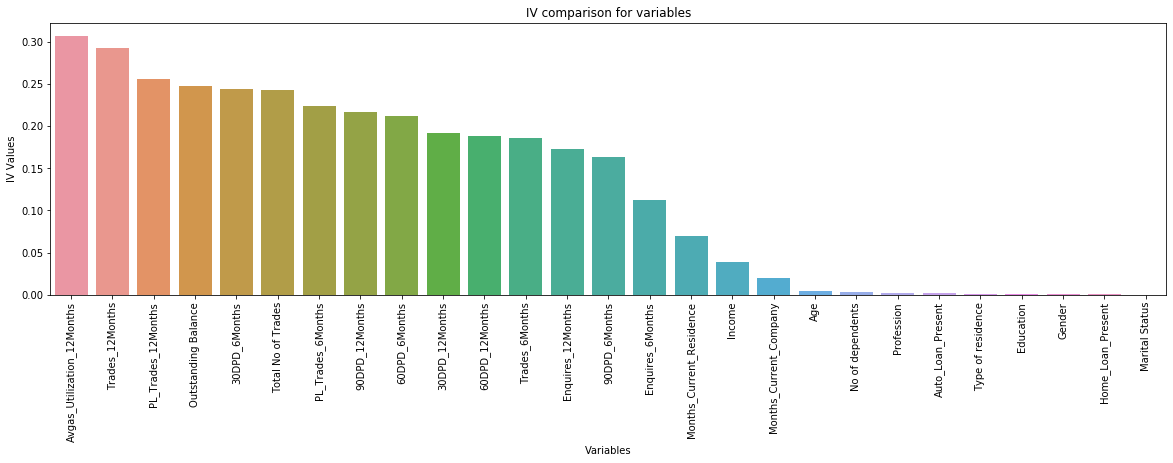

In [229]:
## plotting all the consolidated IV values of the Master variable
plt.figure(figsize=(20,5))
ax = sns.barplot(x='Variable', y='IV', data=Master_IV.sort_values(by='IV', ascending = False))
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('IV comparison for variables')
plt.xlabel('Variables')
plt.ylabel('IV Values')
plt.show()

The `Avgas_Utilization_12Months` have more prediction power compared to other Master variable

### Step 5(b) :- Create Woe Dataframe<a id="2.52"></a>

In [230]:
## creating Master WoE dataframe from original Master dataframe
WOE_Master_df = create_woe_dataframe(Master_Without_Imputation,Master_WOE)
WOE_Master_df.head()

,Application ID,90DPD_6Months,60DPD_6Months,30DPD_6Months,90DPD_12Months,60DPD_12Months,30DPD_12Months,Avgas_Utilization_12Months,Trades_6Months,Trades_12Months,...,Age,Gender,Marital Status,No of dependents,Income,Education,Profession,Type of residence,Months_Current_Residence,Months_Current_Company
0,954457215.0,-0.261365,-0.33702,-0.387448,-0.357329,-0.352585,-0.269583,-0.802205,-0.543935,-0.817152,...,0.038430,0.031600,-0.003867,-0.085864,-0.205896,0.018027,-0.028132,-0.004057,-0.061038,-0.291373
1,432830445.0,-0.261365,-0.33702,-0.387448,-0.357329,-0.352585,-0.269583,-0.802205,-0.543935,-0.817152,...,0.007484,-0.009922,-0.003867,-0.026213,-0.331147,-0.018719,-0.013872,-0.004057,-0.061038,-0.148400
2,941387308.0,-0.261365,-0.33702,-0.387448,-0.357329,-0.352585,-0.269583,-0.795097,-0.543935,-0.894590,...,0.007484,-0.009922,0.022652,-0.085864,-0.179334,0.018027,-0.013872,-0.004057,-0.061038,-0.148400
3,392161677.0,-0.261365,-0.33702,-0.387448,-0.357329,-0.352585,-0.269583,-0.673300,-0.543935,-0.894590,...,-0.040578,-0.009922,-0.003867,0.039511,-0.331147,0.018027,0.092183,-0.004057,-0.061038,-0.291373
4,182011211.0,-0.261365,-0.33702,-0.387448,-0.357329,-0.352585,-0.269583,-0.469542,-0.543935,-0.894590,...,0.001082,0.031600,-0.003867,0.005715,-0.179334,-0.018719,-0.028132,-0.004057,-0.061038,-0.148400


In [231]:
#lets remove unrequired columns
WOE_Master_df= WOE_Master_df.drop(['Application ID'],axis=1)

### Step 5(c) :- Test Train Split<a id="2.53"></a>

In [232]:
# Putting feature variable to X
X = WOE_Master_df.drop(['Performance Tag'],axis=1)
# Putting response variable to y
y = WOE_Master_df['Performance Tag']

In [233]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

In [234]:
#create copy of X_train
X_train_copy=pd.DataFrame(X_train).copy()

### Step 5(d) :- Building  Model with Master Data(with WOE imputation) <a id="2.54">

 **Model 1** - `Building Logistic Regression Model on WOE Master Dataset`

##### Lets Build with top 15 variables

In [235]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 15)
rfe = rfe.fit(X_train, y_train)

In [236]:
col = X_train.columns[rfe.support_]
print(col)
X_train_rfe=X_train[col]

Index(['60DPD_6Months', '30DPD_6Months', '30DPD_12Months',
       'Avgas_Utilization_12Months', 'Trades_12Months', 'Enquires_6Months',
       'Home_Loan_Present', 'Age', 'Gender', 'Marital Status',
       'No of dependents', 'Education', 'Profession', 'Type of residence',
       'Months_Current_Company'],
      dtype='object')


##### 1. Make model with top 15 rfe variables

In [237]:
#Making model with top rfe variables
X_train_rfe, lm_rfe , highest_pvalue_variable= get_model_and_print_summary(X_train_rfe)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                49910
Model:                            GLM   Df Residuals:                    49894
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8173.8
Date:                Mon, 16 Dec 2019   Deviance:                       16348.
Time:                        21:18:52   Pearson chi2:                 4.94e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

##### 2. Rebuild model after dropping `Marital Status`

In [238]:
#drop column having higher p value and rebuild the model again
X_train_rfe, lm_rfe,highest_pvalue_variable = get_model_and_print_summary(X_train_rfe.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                49910
Model:                            GLM   Df Residuals:                    49895
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8174.1
Date:                Mon, 16 Dec 2019   Deviance:                       16348.
Time:                        21:18:53   Pearson chi2:                 4.93e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

##### 3. Rebuild model after dropping `Gender`

In [239]:
#drop column having higher p value and rebuild the model again
X_train_rfe, lm_rfe,highest_pvalue_variable = get_model_and_print_summary(X_train_rfe.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                49910
Model:                            GLM   Df Residuals:                    49896
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8174.4
Date:                Mon, 16 Dec 2019   Deviance:                       16349.
Time:                        21:18:54   Pearson chi2:                 4.93e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

##### 4. Rebuild model after dropping `No of dependents`

In [240]:
#drop column having higher p value and rebuild the model again
X_train_rfe, lm_rfe,highest_pvalue_variable = get_model_and_print_summary(X_train_rfe.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                49910
Model:                            GLM   Df Residuals:                    49897
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8174.8
Date:                Mon, 16 Dec 2019   Deviance:                       16350.
Time:                        21:18:54   Pearson chi2:                 4.93e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

##### 5. Rebuild model after dropping `Home_Loan_Present`

In [241]:
#drop column having higher p value and rebuild the model again
X_train_rfe, lm_rfe,highest_pvalue_variable = get_model_and_print_summary(X_train_rfe.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                49910
Model:                            GLM   Df Residuals:                    49898
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8175.4
Date:                Mon, 16 Dec 2019   Deviance:                       16351.
Time:                        21:18:55   Pearson chi2:                 4.93e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

##### 6. Rebuild model after dropping `Education`

In [242]:
#drop column having higher p value and rebuild the model again
X_train_rfe, lm_rfe,highest_pvalue_variable = get_model_and_print_summary(X_train_rfe.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                49910
Model:                            GLM   Df Residuals:                    49899
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8175.9
Date:                Mon, 16 Dec 2019   Deviance:                       16352.
Time:                        21:18:56   Pearson chi2:                 4.93e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

##### 7. Rebuild model after dropping `30DPD_12Months`

In [243]:
#drop column having higher p value and rebuild the model again
X_train_rfe, lm_rfe,highest_pvalue_variable = get_model_and_print_summary(X_train_rfe.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                49910
Model:                            GLM   Df Residuals:                    49900
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8176.8
Date:                Mon, 16 Dec 2019   Deviance:                       16354.
Time:                        21:18:58   Pearson chi2:                 4.93e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

##### 8. Rebuild model after dropping `60DPD_6Months`

In [244]:
#drop column having higher p value and rebuild the model again
X_train_rfe, lm_rfe,highest_pvalue_variable = get_model_and_print_summary(X_train_rfe.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                49910
Model:                            GLM   Df Residuals:                    49901
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8178.1
Date:                Mon, 16 Dec 2019   Deviance:                       16356.
Time:                        21:19:00   Pearson chi2:                 4.94e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

##### 8. Rebuild model after dropping `Profession`

In [245]:
#drop column having higher p value and rebuild the model again
X_train_rfe, lm_rfe,highest_pvalue_variable = get_model_and_print_summary(X_train_rfe.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                49910
Model:                            GLM   Df Residuals:                    49902
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8179.6
Date:                Mon, 16 Dec 2019   Deviance:                       16359.
Time:                        21:19:01   Pearson chi2:                 4.93e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

##### 9. Rebuild model after dropping `Months_Current_Company`

In [246]:
#drop column having higher p value and rebuild the model again
X_train_rfe, lm_rfe,highest_pvalue_variable = get_model_and_print_summary(X_train_rfe.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                49910
Model:                            GLM   Df Residuals:                    49903
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8181.3
Date:                Mon, 16 Dec 2019   Deviance:                       16363.
Time:                        21:19:02   Pearson chi2:                 4.94e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

##### 10. Rebuild model after dropping `Type of residence`

In [247]:
#drop column having higher p value and rebuild the model again
X_train_rfe, lm_rfe,highest_pvalue_variable = get_model_and_print_summary(X_train_rfe.drop(highest_pvalue_variable, axis=1))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                49910
Model:                            GLM   Df Residuals:                    49904
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8183.6
Date:                Mon, 16 Dec 2019   Deviance:                       16367.
Time:                        21:19:02   Pearson chi2:                 4.94e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [248]:
#Lets check ViF scores
get_vif(X_train_rfe)

                     Features   VIF
3             Trades_12Months  2.25
2  Avgas_Utilization_12Months  2.16
1               30DPD_6Months  1.71
4            Enquires_6Months  1.41
0                       const  1.07
5                         Age  1.00


**All variables have a good value of VIF. So we need not drop any more variables and we can proceed with making predictions using this model only**

In [249]:
X_train_final = X_train_rfe
lm_final = lm_rfe

##### i . Analyzing top predictors

In [250]:
top_predictor_variables=list(X_train_final.columns)
top_predictor_variables.remove('const')
print('The Top Predictors are :-')
top_predictor_variables

The Top Predictors are :-


['30DPD_6Months',
 'Avgas_Utilization_12Months',
 'Trades_12Months',
 'Enquires_6Months',
 'Age']

#### ii.  Draw ROC Curve

In [251]:
#Let's create a dataframe with lead score and converted values.
y_train_final = pd.DataFrame({'predicted_response':y_train.values, 'probablity_predicted_response':lm_final.predict(X_train_final)})
y_train_final.head()

,predicted_response,probablity_predicted_response
559,0.0,0.017189
54692,0.0,0.048464
25571,0.0,0.026877
20641,0.0,0.015116
33479,0.0,0.031147


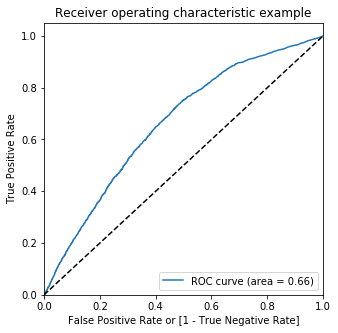

In [252]:
fpr, tpr, thresholds = roc_curve(y_train_final.predicted_response,y_train_final.probablity_predicted_response, drop_intermediate=False )
draw_roc(y_train_final.predicted_response, y_train_final.probablity_predicted_response)

#### iii.  Obtain Optimum Cutoff between sensitivity , specificity & Accuracy

In [253]:
numbers = [round(x * 0.05, 2) for x in range(0, 20)]
y_train_pred_final = y_train_final

for i in numbers:
    y_train_pred_final[i]= y_train_final.probablity_predicted_response.map(lambda x: 1 if x > i else 0)

y_train_pred_final.head()

,predicted_response,probablity_predicted_response,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,...,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95
559,0.0,0.017189,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
54692,0.0,0.048464,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25571,0.0,0.026877,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20641,0.0,0.015116,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33479,0.0,0.031147,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [254]:
#Lets create cut off dataframe having accuracy sensitivity & specificity
cutoff_df= create_cutoff_df(y_train_pred_final)
cutoff_df.head()

,Accuracy,Sensitivity,Specificity
0.00,0.040773,1.000000,0.000000
0.05,0.664055,0.564619,0.668282
0.10,0.959207,0.000000,0.999979
0.15,0.959227,0.000000,1.000000
0.20,0.959227,0.000000,1.000000


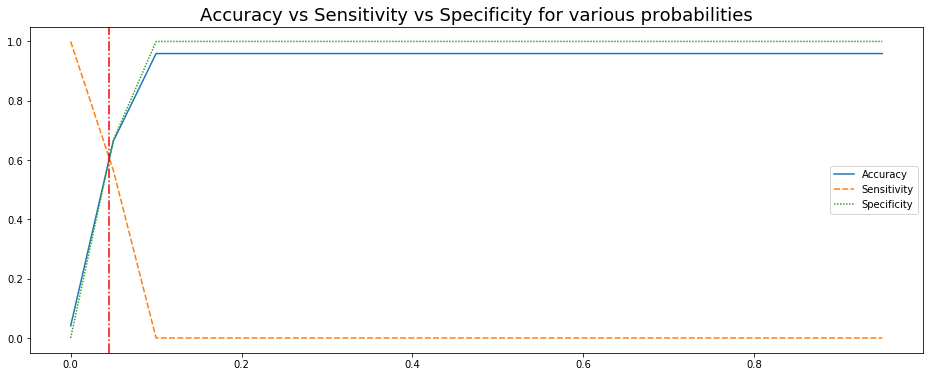

In [255]:
#Visualize accuracy, sensitivity and specificity graph
accuracy_sensitivity_specificty_graph(cutoff_df,0.045)

Graph Analysis :-  
`ROC curve shows that 0.045 is the optimum point to take it as a cutoff probability`

#### iv.Precision and Recall TradeOff

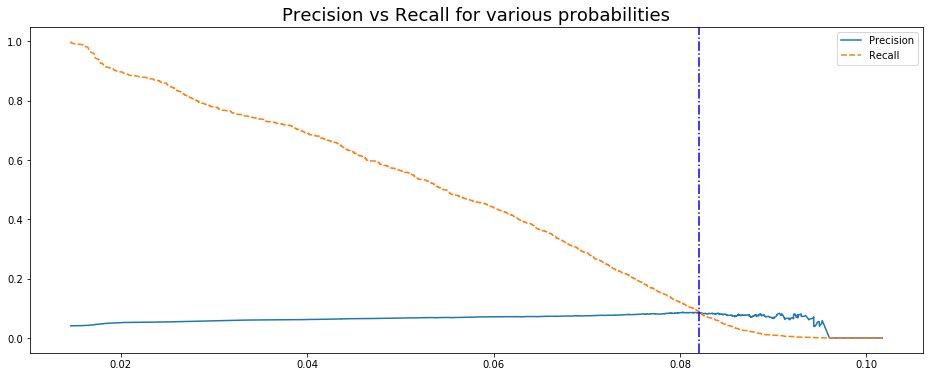

In [256]:
p, r, thresholds = precision_recall_curve(y_train_final.predicted_response, y_train_final.probablity_predicted_response)
cutoff_df = pd.DataFrame({'Precision': pd.Series(p[:-1], index=thresholds),'Recall':pd.Series(r[:-1], index=thresholds)})
#Visualize accuracy, sensitivity and specificity graph
accuracy_precision_graph(cutoff_df,0.082)

The optimum value from Precision and Recall is `0.082`

In [257]:
cutoff_probability1 = 0.045
predicted_1 = y_train_pred_final.probablity_predicted_response.map( lambda x: 1 if x > cutoff_probability1 else 0)
metrics_dataframe(y_train_pred_final.predicted_response, predicted_1)

Confusion Matrix is :-
[[29536 18339]
 [  763  1272]]
Metrics and their score for above confusion metris :-


,Metric,Score
0,Sensitivity/Recall,0.625061
1,Specificity,0.616940
2,Accuracy,0.617271
3,Precision,0.064862
4,False Positive Rate,0.383060
5,Positive Predictive Value,0.064862
6,Negative Predictive Value,0.974818


In [258]:
cutoff_probability2 = 0.082
predicted_2 = y_train_pred_final.probablity_predicted_response.map( lambda x: 1 if x > cutoff_probability2 else 0)
metrics_dataframe(y_train_pred_final.predicted_response, predicted_2)

Confusion Matrix is :-
[[45913  1962]
 [ 1851   184]]
Metrics and their score for above confusion metris :-


,Metric,Score
0,Sensitivity/Recall,0.090418
1,Specificity,0.959018
2,Accuracy,0.923602
3,Precision,0.085741
4,False Positive Rate,0.040982
5,Positive Predictive Value,0.085741
6,Negative Predictive Value,0.961247


In [259]:
#Considering '0.045' as final cut off as it have better results
cutoff_probability = 0.045
predicted_final = y_train_pred_final.probablity_predicted_response.map( lambda x: 1 if x > cutoff_probability else 0)
Master_LR_Woe=metrics_dataframe(y_train_final.predicted_response, predicted_final)
Master_LR_Woe

Confusion Matrix is :-
[[29536 18339]
 [  763  1272]]
Metrics and their score for above confusion metris :-


,Metric,Score
0,Sensitivity/Recall,0.625061
1,Specificity,0.616940
2,Accuracy,0.617271
3,Precision,0.064862
4,False Positive Rate,0.383060
5,Positive Predictive Value,0.064862
6,Negative Predictive Value,0.974818


###### Analysis of Metrics of Logistic Regression on WOE Master Dataset:-  
   -  `Sensitivity/Recall`, `Specificity` & `Accuracy` of `Logistic Regression` is higher than  `60%` which is quite good
   - But  `Precision` of `Logistic Regression` is `6.5%` which is also quite low

Lets Make model with Random Forest

In [260]:
#Create datframe having actual, predicted & probability Probablity response
Master_LR_Woe_Response_df=create_response_dataframe(0.045)
Master_LR_Woe_Response_df.head()

,actual_response,probablity_predicted_response,predicted_response
69693,0.0,0.101717,1
67296,0.0,0.099391,1
65153,1.0,0.099391,1
67842,0.0,0.099391,1
65319,0.0,0.099391,1


In [261]:
#Create Lift dataframe
Master_LR_Woe_Lift_df=generate_lift_dataframe(Master_LR_Woe_Response_df)
Master_LR_Woe_Lift_df

,decile,total,actual_response,cumresp,gain,cumlift
9,1,7129,565,565,19.159037,1.915904
8,2,7125,506,1071,36.317396,1.815870
7,3,7134,422,1493,50.627331,1.687578
6,4,7097,378,1871,63.445236,1.586131
5,5,7163,331,2202,74.669379,1.493388
4,6,7118,227,2429,82.366904,1.372782
3,7,7058,215,2644,89.657511,1.280822
2,8,7179,100,2744,93.048491,1.163106
1,9,6908,104,2848,96.575110,1.073057
0,10,7390,101,2949,100.000000,1.000000


From above dataframe we can see that 75% tdefaulters can be detected by targeting 50% applicants

##### **Model 2** - `Building Random Forest Model on WOE Master Datset`

##### A. Create Random Forest

In [262]:
X_train=X_train_copy
#Create Random Forest
rfc = RandomForestClassifier(class_weight ='balanced', n_jobs = -1)
rfc.fit(X_train, y_train)

#make predictions
y_predicted = rfc.predict(X_test)

#check metrics
print(classification_report(y_test, y_predicted))
metrics_dataframe(y_test, y_predicted)

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     20477
         1.0       0.00      0.00      0.00       914

    accuracy                           0.96     21391
   macro avg       0.48      0.50      0.49     21391
weighted avg       0.92      0.96      0.94     21391

Confusion Matrix is :-
[[20473     4]
 [  914     0]]
Metrics and their score for above confusion metris :-


,Metric,Score
0,Sensitivity/Recall,0.000000
1,Specificity,0.999805
2,Accuracy,0.957085
3,Precision,0.000000
4,False Positive Rate,0.000195
5,Positive Predictive Value,0.000000
6,Negative Predictive Value,0.957264


#### B. Hyper Parameter Tuning

In [263]:
param_grid = {
    'max_depth': [2,4, 8],
    'min_samples_leaf': range(10, 50, 10),
    'min_samples_split': range(10, 50, 10),
    'n_estimators': [10, 30, 50]
}
#Best Paramaters  :-  {'max_depth': 8, 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 30}
rfc = GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced'),
                        param_grid=param_grid, scoring='accuracy',
                        cv=KFold(n_splits=3, shuffle=True, random_state=42),
                        n_jobs=-1,
                        verbose=1,
                        return_train_score=True) 
rfc.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  2.4min finished


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                             

In [264]:
print('Best Paramaters  :- ',rfc.best_params_)
print('Best Score  :- ',rfc.best_score_)
print('Best Estimators  :- ',rfc.best_estimator_)

Best Paramaters  :-  {'max_depth': 8, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 30}
Best Score  :-  0.7028851933480265
Best Estimators  :-  RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=10,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=30, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)


##### C. Building Final Random Forest

In [265]:
rfc_final = RandomForestClassifier(bootstrap=True, class_weight='balanced',criterion='gini',
                       max_depth=rfc.best_estimator_.max_depth, 
                       max_features=rfc.best_estimator_.max_features,
                       min_samples_leaf=rfc.best_estimator_.min_samples_leaf,
                       min_samples_split=rfc.best_estimator_.min_samples_split,
                       n_estimators=rfc.best_estimator_.n_estimators,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_weight_fraction_leaf=0.0,
                        n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

rfc_final.fit(X_train, y_train)
y_predicted = rfc_final.predict(X_test)

In [266]:
print('Classification Report :-')
print(classification_report(y_test, y_predicted))

Classification Report :-
              precision    recall  f1-score   support

         0.0       0.97      0.67      0.79     20477
         1.0       0.07      0.56      0.12       914

    accuracy                           0.66     21391
   macro avg       0.52      0.61      0.46     21391
weighted avg       0.93      0.66      0.76     21391



In [267]:
Master_RF_Woe=metrics_dataframe(y_test, y_predicted)
Master_RF_Woe

Confusion Matrix is :-
[[13621  6856]
 [  398   516]]
Metrics and their score for above confusion metris :-


,Metric,Score
0,Sensitivity/Recall,0.564551
1,Specificity,0.665185
2,Accuracy,0.660885
3,Precision,0.069995
4,False Positive Rate,0.334815
5,Positive Predictive Value,0.069995
6,Negative Predictive Value,0.971610


###### Analysis of Metrics of Random Forest on WOE Dataset:-  
   -  `Specificity` & `Accuracy` of `Random Forest` is higher than  `60%` which is quite good
   -  `Sensitivity/Recall` of `Random Forest` is lower than  `60%` which is not good(for final model)
   - But `Precision` of `Random Forest` is `6.6%` which is also quite low

Lets Make model with Decision trees

 **Model 3** - `Building Decision Tree on WOE Master Dataset`

##### i. Building Decision Tree

In [268]:
param_grid = {
    'max_depth': [2, 4, 8, 16],
    'min_samples_leaf': range(10, 50, 10),
    'min_samples_split': range(10, 50, 10),
    'max_features': range(10, 30, 10)
}

dt = GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced'),
                        param_grid=param_grid,
                        scoring='accuracy',
                        cv=KFold(n_splits=5, shuffle=True, random_state=42),
                        n_jobs=-1,
                        verbose=1,
                        return_train_score=True) 

#dt.fit(telecom.drop('churn', axis=1), telecom['churn'])
dt.fit(X_train, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:   44.5s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [2, 4, 8, 16],
                   

In [269]:
#Check best Parameters
print(dt.best_score_)
print(dt.best_params_)

0.7203766780204368
{'max_depth': 16, 'max_features': 20, 'min_samples_leaf': 10, 'min_samples_split': 10}


##### ii. Building Decision tree with best parameters

In [270]:
#Building Decision tree
decision_tree_final = DecisionTreeClassifier(class_weight='balanced', max_depth=dt.best_params_['max_depth'],
                                       min_samples_leaf=dt.best_params_['min_samples_leaf'],
                                       min_samples_split=dt.best_params_['min_samples_split'],
                                       max_features=dt.best_params_['max_features'],random_state=42)

decision_tree_final.fit(X_train, y_train)

#Making Prediction
y_predicted = decision_tree_final.predict(X_test)

#Check Metrics
#print(classification_report(y_test, y_predicted))
Master_DT_Woe=metrics_dataframe(y_test, y_predicted)
Master_DT_Woe

Confusion Matrix is :-
[[14911  5566]
 [  592   322]]
Metrics and their score for above confusion metris :-


,Metric,Score
0,Sensitivity/Recall,0.352298
1,Specificity,0.728183
2,Accuracy,0.712122
3,Precision,0.054688
4,False Positive Rate,0.271817
5,Positive Predictive Value,0.054688
6,Negative Predictive Value,0.961814


###### Analysis of Metrics of Decsion Trees on WOE Dataset:-  
   -  `Specificity` & `Accuracy` of `Decsion Trees` is higher than  `60%` which is quite good
   -  `Sensitivity/Recall` of `Decsion Trees` is lower than  `60%` which is quite low
   - But `Precision` of `Decsion Trees ` is `5%` which is also quite low

In [271]:
##### Checking Top features of Decision Tree
Top_Features_df = pd.DataFrame(list(zip(list(X_train.columns)[:-1], decision_tree_final.feature_importances_)),
             columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

Top_Features_df.head()

,Feature,Importance
6,Avgas_Utilization_12Months,0.158805
17,Age,0.083225
21,Income,0.080543
20,No of dependents,0.068427
8,Trades_12Months,0.052207


## Part 4 :- `Model Selection & Model Evaluation` <a id="3.0"></a>

### Step 1:- Selection of Best Model<a id="3.1"></a>

In [272]:
##### Comparing metrics of all models
Summary =pd.concat([Master_LR_Woe,Master_RF_Woe.Score,Master_DT_Woe.Score,Master_LR_Non_Woe.Score,Master_RF_Non_Woe.Score], axis = 1) 
Summary.columns=['Metrics','Master - LR - Woe','Master - RF - Woe','Master - DT - Woe','Master - LR - Non Woe','Master - RF - Non Woe']
Summary

,Metrics,Master - LR - Woe,Master - RF - Woe,Master - DT - Woe,Master - LR - Non Woe,Master - RF - Non Woe
0,Sensitivity/Recall,0.625061,0.564551,0.352298,0.674430,0.706621
1,Specificity,0.616940,0.665185,0.728183,0.551976,0.553286
2,Accuracy,0.617271,0.660885,0.712122,0.557115,0.559804
3,Precision,0.064862,0.069995,0.054688,0.061861,0.065614
4,False Positive Rate,0.383060,0.334815,0.271817,0.448024,0.446714
5,Positive Predictive Value,0.064862,0.069995,0.054688,0.061861,0.065614
6,Negative Predictive Value,0.974818,0.971610,0.961814,0.974814,0.977002


**FINAL SELECTED MODEL - Logistic Regression ON WOE DATASET**

***Reasons for selection of this model:-***  
- Our Business Objective is  `acquire the right customers`, hence we should select model with good Sensitivity & specificity value.
- From Above Summary Table we can see that, the Model having good Sensitivity & specificity is `Logistic regression model build on WOE DATASET`
- Hence we are selecting `Logistic Regression model build on WOE DATASET` as our final model

### Step 2 :- Model Evaluation <a id="3.2"></a>

##### i. Making predictions on rejected candidates

In [273]:
Rejected_df=Master_Without_Imputation[Master_Without_Imputation['Performance Tag'].isnull()]
Rejected_df.head()

,Application ID,90DPD_6Months,60DPD_6Months,30DPD_6Months,90DPD_12Months,60DPD_12Months,30DPD_12Months,Avgas_Utilization_12Months,Trades_6Months,Trades_12Months,...,Age,Gender,Marital Status,No of dependents,Income,Education,Profession,Type of residence,Months_Current_Residence,Months_Current_Company
69609,906908303,0,0,2,1,2,3,30.0,4.0,12,...,35,M,Single,1.0,6.0,Bachelor,SAL,Rented,22,18
69610,10990583,1,1,1,3,2,2,16.0,3.0,7,...,47,F,Married,4.0,12.0,Masters,SE,Rented,122,25
69611,589678446,3,4,5,3,5,6,83.0,2.0,7,...,46,M,Married,3.0,7.0,Professional,SE,Rented,10,31
69612,809411322,1,3,4,3,4,5,87.0,2.0,7,...,41,M,Married,3.0,18.0,Masters,SAL,Rented,6,47
69613,150246616,2,2,4,3,2,6,42.0,3.0,7,...,42,F,Married,4.0,17.0,Phd,SAL,Rented,8,49


In [274]:
print('Shape of data Frame:- ',Rejected_df.shape)

Shape of data Frame:-  (1425, 29)


In [275]:
Rejected_df.isnull().sum()

Application ID                   0
90DPD_6Months                    0
60DPD_6Months                    0
30DPD_6Months                    0
90DPD_12Months                   0
60DPD_12Months                   0
30DPD_12Months                   0
Avgas_Utilization_12Months      35
Trades_6Months                   0
Trades_12Months                  0
PL_Trades_6Months                0
PL_Trades_12Months               0
Enquires_6Months                 0
Enquires_12Months                0
Home_Loan_Present                0
Outstanding Balance              0
Total No of Trades               0
Auto_Loan_Present                0
Performance Tag               1425
Age                              0
Gender                           0
Marital Status                   0
No of dependents                 0
Income                           0
Education                        1
Profession                       1
Type of residence                0
Months_Current_Residence         0
Months_Current_Compa

In [276]:
Rejected_df['Performance Tag']=1

In [277]:
Rejected_df.fillna(0, inplace=True)

In [278]:
# Droping unrequired column
Rejected_df.drop(columns = ['Application ID'], inplace = True)

In [279]:
# Putting feature variable to X
X_test = Rejected_df.drop(['Performance Tag'],axis=1)

# Putting response variable to y
y_test = Rejected_df['Performance Tag']

In [280]:
# Create list of numerical variables
num_vars = ['Avgas_Utilization_12Months','Outstanding Balance','Total No of Trades','Age','Income',
            'Months_Current_Residence','Months_Current_Company']

# Apply scaler() to all the columns in `X_test`
X_test[num_vars] = scaler.fit_transform(X_test[num_vars])
X_test.head()

,90DPD_6Months,60DPD_6Months,30DPD_6Months,90DPD_12Months,60DPD_12Months,30DPD_12Months,Avgas_Utilization_12Months,Trades_6Months,Trades_12Months,PL_Trades_6Months,...,Age,Gender,Marital Status,No of dependents,Income,Education,Profession,Type of residence,Months_Current_Residence,Months_Current_Company
69609,0,0,2,1,2,3,0.297030,4.0,12,3,...,0.302326,M,Single,1.0,0.027027,Bachelor,SAL,Rented,0.133333,0.208333
69610,1,1,1,3,2,2,0.158416,3.0,7,3,...,0.581395,F,Married,4.0,0.135135,Masters,SE,Rented,0.966667,0.305556
69611,3,4,5,3,5,6,0.821782,2.0,7,2,...,0.558140,M,Married,3.0,0.045045,Professional,SE,Rented,0.033333,0.388889
69612,1,3,4,3,4,5,0.861386,2.0,7,1,...,0.441860,M,Married,3.0,0.243243,Masters,SAL,Rented,0.000000,0.611111
69613,2,2,4,3,2,6,0.415842,3.0,7,2,...,0.465116,F,Married,4.0,0.225225,Phd,SAL,Rented,0.016667,0.638889


In [281]:
y_predicted_prob =lm_final.predict(sm.add_constant(X_test)[X_train_final.columns])
y_predicted_prob.head()

69609    0.946712
69610    0.742796
69611    0.859062
69612    0.910467
69613    0.870248
dtype: float64

In [282]:
cutoff_probability = 0.045
predicted = pd.DataFrame(y_predicted_prob.map( lambda x: 1 if x > cutoff_probability else 0),columns =['y_predicted'])
predicted.head()

,y_predicted
69609,1
69610,1
69611,1
69612,1
69613,1


In [283]:
predicted['y_predicted_prob'] =y_predicted_prob
predicted['y_test'] =y_test
predicted.head()

,y_predicted,y_predicted_prob,y_test
69609,1,0.946712,1
69610,1,0.742796,1
69611,1,0.859062,1
69612,1,0.910467,1
69613,1,0.870248,1


In [284]:
predicted.reset_index(drop=True, inplace=True)
predicted

,y_predicted,y_predicted_prob,y_test
0,1,0.946712,1
1,1,0.742796,1
2,1,0.859062,1
3,1,0.910467,1
4,1,0.870248,1
...,...,...,...
1420,1,0.947536,1
1421,1,0.670693,1
1422,1,0.827525,1
1423,1,0.854037,1


In [285]:
print('Minimum Probability of Default for Rejected candidate :-', predicted.y_predicted_prob.min())
print('Maximum Probability  of Default for Rejected candidate:-',predicted.y_predicted_prob.max())
print('Average  Probability of Default for Rejected candidate:-', predicted.y_predicted_prob.mean())

Minimum Probability of Default for Rejected candidate :- 0.19262073358598422
Maximum Probability  of Default for Rejected candidate:- 0.9915658041517841
Average  Probability of Default for Rejected candidate:- 0.8220809193977572


In [286]:
print('Number of Actual Defaulters :-', predicted.y_test.sum())
print('Number of Predicted Defaulters :-',predicted.y_predicted.sum())
print('Accuracy of Model  :-', 100*(predicted.y_test.sum()/ predicted.y_predicted.sum()))

Number of Actual Defaulters :- 1425
Number of Predicted Defaulters :- 1425
Accuracy of Model  :- 100.0


Thus all the rejected applicants are detected by our model as possible defaulters

### Step 3 :- Application Scorecard<a id="3.3"></a>

It is required to build an application scorecard with the good to bad odds. The ideal model that is suitable for such a case is **Logistic Regression** model with all variables(combined data of demographics and CreditBureau). Similar representation of non-defaulters to defaulters we also have in our **WoE transformed** representation. So, we’ll need both our logistic regression coefficients that we got from fitting our model (**WoE Logistic Regression model combined data model with L1 regularization prepared earlier**) as well as our WOE dataset with the transformed WOE values.

The scorecard in this case will be evaluated as :

**target_score = 400**

**target_odds = 10**

**pts_double_odds = 20**

**factor = pts_double_odds / log10(2)**

**offset = target_score - factor X log10(target_odds)**

Finally,

**scorecard['score'] = offset - factor X scorecard['logit']**

**Note:** The negative sign for the term of scorecard['logit'] is applied as model is evaluating probabilities ofodds of defaults (bad). However, we tend to provide a high score to the persons who are good. Therefore, the sign is negative.

In [287]:
Target_Score = 400
Target_Odds = 10
pts_double_odds = 20

Factor = pts_double_odds / np.log10(2)
Offset = Target_Score - Factor * np.log10(Target_Odds)
print("Value of Factor =",Factor)
print("VAlue of Offset =",Offset)

Value of Factor = 66.43856189774725
VAlue of Offset = 333.56143810225274


#### 1.Creation of Scorecard for Approved Applicants(Demo data +Credit data)

In [288]:
## Checking WOE master data
WOE_Master_df.head()

,90DPD_6Months,60DPD_6Months,30DPD_6Months,90DPD_12Months,60DPD_12Months,30DPD_12Months,Avgas_Utilization_12Months,Trades_6Months,Trades_12Months,PL_Trades_6Months,...,Age,Gender,Marital Status,No of dependents,Income,Education,Profession,Type of residence,Months_Current_Residence,Months_Current_Company
0,-0.261365,-0.33702,-0.387448,-0.357329,-0.352585,-0.269583,-0.802205,-0.543935,-0.817152,-0.649917,...,0.038430,0.031600,-0.003867,-0.085864,-0.205896,0.018027,-0.028132,-0.004057,-0.061038,-0.291373
1,-0.261365,-0.33702,-0.387448,-0.357329,-0.352585,-0.269583,-0.802205,-0.543935,-0.817152,-0.649917,...,0.007484,-0.009922,-0.003867,-0.026213,-0.331147,-0.018719,-0.013872,-0.004057,-0.061038,-0.148400
2,-0.261365,-0.33702,-0.387448,-0.357329,-0.352585,-0.269583,-0.795097,-0.543935,-0.894590,-0.649917,...,0.007484,-0.009922,0.022652,-0.085864,-0.179334,0.018027,-0.013872,-0.004057,-0.061038,-0.148400
3,-0.261365,-0.33702,-0.387448,-0.357329,-0.352585,-0.269583,-0.673300,-0.543935,-0.894590,-0.649917,...,-0.040578,-0.009922,-0.003867,0.039511,-0.331147,0.018027,0.092183,-0.004057,-0.061038,-0.291373
4,-0.261365,-0.33702,-0.387448,-0.357329,-0.352585,-0.269583,-0.469542,-0.543935,-0.894590,-0.649917,...,0.001082,0.031600,-0.003867,0.005715,-0.179334,-0.018719,-0.028132,-0.004057,-0.061038,-0.148400


In [289]:
# Putting feature variable to X
X_train = WOE_Master_df.drop(['Performance Tag'],axis=1)
# Putting response variable to y
y_train = WOE_Master_df['Performance Tag']

In [290]:
## In order to find intercept and co efficient of all variables lets make the logistic regression model
Model_Scorecard=LogisticRegression(C=0.01,penalty="l1",class_weight='balanced')
Model_Scorecard.fit(X_train,y_train)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [291]:
## checking the coefficient
Model_Scorecard.coef_[0]

array([0.        , 0.        , 0.15454455, 0.03786393, 0.        ,
       0.10667876, 0.47498623, 0.        , 0.30888897, 0.00446691,
       0.01961911, 0.02047665, 0.16330038, 0.        , 0.12573731,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [292]:
## checking the intercept
intercept = Model_Scorecard.intercept_[0]
intercept

-0.0038402415721514906

In [293]:
## combining coefficients with their respective variable names
LR_Coefficient = pd.DataFrame({'Cols':X_train.columns,'Coefficient':Model_Scorecard.coef_[0]})
LR_Coefficient = LR_Coefficient.set_index('Cols')
LR_Coefficient

## removing all the variables that have coefficients as zero
## all these variables are the one that have been nullified by lasso regularization
LR_Coefficient= LR_Coefficient[LR_Coefficient.Coefficient !=0]
LR_Coefficient

,Coefficient
Cols,
30DPD_6Months,0.154545
90DPD_12Months,0.037864
30DPD_12Months,0.106679
Avgas_Utilization_12Months,0.474986
Trades_12Months,0.308889
PL_Trades_6Months,0.004467
PL_Trades_12Months,0.019619
Enquires_6Months,0.020477
Enquires_12Months,0.163300


In [294]:
## Multiply linear regression coefficients to observation WOE Values
Scorecard_Master = WOE_Master_df[LR_Coefficient.index].apply(lambda x: x*LR_Coefficient['Coefficient'] ,axis=1)
Scorecard_Master.head()

,30DPD_6Months,90DPD_12Months,30DPD_12Months,Avgas_Utilization_12Months,Trades_12Months,PL_Trades_6Months,PL_Trades_12Months,Enquires_6Months,Enquires_12Months,Outstanding Balance
0,-0.059878,-0.01353,-0.028759,-0.381036,-0.252409,-0.002903,-0.013482,-0.006533,-0.081468,-0.118110
1,-0.059878,-0.01353,-0.028759,-0.381036,-0.252409,-0.002903,-0.013482,-0.006533,-0.081468,-0.103129
2,-0.059878,-0.01353,-0.028759,-0.377660,-0.276329,-0.002903,-0.013482,-0.006533,-0.081468,-0.118110
3,-0.059878,-0.01353,-0.028759,-0.319808,-0.276329,-0.002903,-0.013482,-0.006533,-0.081468,0.025303
4,-0.059878,-0.01353,-0.028759,-0.223026,-0.276329,-0.002903,-0.013482,-0.006533,-0.081468,-0.118110


In [295]:
## Calclate logit,odds,probs & score 
Scorecard_Master['Logit'] = Scorecard_Master.sum(axis=1) + intercept
Scorecard_Master['odds'] = np.exp(-Scorecard_Master['Logit'])
Scorecard_Master['probs'] = Scorecard_Master['odds'] / (Scorecard_Master['odds'] + 1)
Scorecard_Master['Score'] = Offset - Factor * Scorecard_Master['Logit']
Scorecard_Master.head()

,30DPD_6Months,90DPD_12Months,30DPD_12Months,Avgas_Utilization_12Months,Trades_12Months,PL_Trades_6Months,PL_Trades_12Months,Enquires_6Months,Enquires_12Months,Outstanding Balance,Logit,odds,probs,Score
0,-0.059878,-0.01353,-0.028759,-0.381036,-0.252409,-0.002903,-0.013482,-0.006533,-0.081468,-0.118110,-0.961948,2.616790,0.723512,397.471893
1,-0.059878,-0.01353,-0.028759,-0.381036,-0.252409,-0.002903,-0.013482,-0.006533,-0.081468,-0.103129,-0.946967,2.577879,0.720505,396.476549
2,-0.059878,-0.01353,-0.028759,-0.377660,-0.276329,-0.002903,-0.013482,-0.006533,-0.081468,-0.118110,-0.982492,2.671103,0.727602,398.836770
3,-0.059878,-0.01353,-0.028759,-0.319808,-0.276329,-0.002903,-0.013482,-0.006533,-0.081468,0.025303,-0.781227,2.184150,0.685944,385.465027
4,-0.059878,-0.01353,-0.028759,-0.223026,-0.276329,-0.002903,-0.013482,-0.006533,-0.081468,-0.118110,-0.827857,2.288410,0.695902,388.563093


In [296]:
# Add Performance_Tag
Scorecard_Master['Performance Tag'] = WOE_Master_df['Performance Tag']
Scorecard_Master.head()

,30DPD_6Months,90DPD_12Months,30DPD_12Months,Avgas_Utilization_12Months,Trades_12Months,PL_Trades_6Months,PL_Trades_12Months,Enquires_6Months,Enquires_12Months,Outstanding Balance,Logit,odds,probs,Score,Performance Tag
0,-0.059878,-0.01353,-0.028759,-0.381036,-0.252409,-0.002903,-0.013482,-0.006533,-0.081468,-0.118110,-0.961948,2.616790,0.723512,397.471893,0.0
1,-0.059878,-0.01353,-0.028759,-0.381036,-0.252409,-0.002903,-0.013482,-0.006533,-0.081468,-0.103129,-0.946967,2.577879,0.720505,396.476549,0.0
2,-0.059878,-0.01353,-0.028759,-0.377660,-0.276329,-0.002903,-0.013482,-0.006533,-0.081468,-0.118110,-0.982492,2.671103,0.727602,398.836770,0.0
3,-0.059878,-0.01353,-0.028759,-0.319808,-0.276329,-0.002903,-0.013482,-0.006533,-0.081468,0.025303,-0.781227,2.184150,0.685944,385.465027,0.0
4,-0.059878,-0.01353,-0.028759,-0.223026,-0.276329,-0.002903,-0.013482,-0.006533,-0.081468,-0.118110,-0.827857,2.288410,0.695902,388.563093,0.0


In [297]:
## checking scores for all the values in performance tag
print('Min value :- ', Scorecard_Master.Score.min())
print('Max value :- ',Scorecard_Master.Score.max())
print('Mean value :- ',Scorecard_Master.Score.mean())
print('Median value :- ',Scorecard_Master.Score.median())

Min value :-  275.2399514244804
Max value :-  399.0610766462579
Mean value :-  344.3438586527226
Median value :-  344.74454245319913


In [298]:
#Finding cut off value in Scorecard for Approved Applicants
for i in range(275,405,5):
    Scorecard_Master_Cut_off=pd.DataFrame()
    Scorecard_Master_Cut_off.actual=Scorecard_Master['Performance Tag']
    Scorecard_Master_Cut_off.predicted=Scorecard_Master.Score.map(lambda x: 0 if x > i else 1)
 
    confusion = confusion_matrix(Scorecard_Master_Cut_off.actual, Scorecard_Master_Cut_off.predicted)
    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives
    
    specificity = TN/float(TN+FP)
    accuracy = accuracy_score(Scorecard_Master_Cut_off.actual, Scorecard_Master_Cut_off.predicted)
    recall = TP/float(TP+FN)

    if specificity >0.60 and recall> 0.6 :
        print('The Cut off Application Score:-  ',i)

The Cut off Application Score:-   325


**Cut off Score value in Scorecard for Approved Applicants is 325**

#### 2.Creation of Scorecard for Rejected Applicants(Demo data +Credit data)

In [299]:
Rejected_df=Master_Without_Imputation[Master_Without_Imputation['Performance Tag'].isnull()]
Rejected_df=Rejected_df.drop(['Application ID'],axis=1)
Rejected_df.head()

,90DPD_6Months,60DPD_6Months,30DPD_6Months,90DPD_12Months,60DPD_12Months,30DPD_12Months,Avgas_Utilization_12Months,Trades_6Months,Trades_12Months,PL_Trades_6Months,...,Age,Gender,Marital Status,No of dependents,Income,Education,Profession,Type of residence,Months_Current_Residence,Months_Current_Company
69609,0,0,2,1,2,3,30.0,4.0,12,3,...,35,M,Single,1.0,6.0,Bachelor,SAL,Rented,22,18
69610,1,1,1,3,2,2,16.0,3.0,7,3,...,47,F,Married,4.0,12.0,Masters,SE,Rented,122,25
69611,3,4,5,3,5,6,83.0,2.0,7,2,...,46,M,Married,3.0,7.0,Professional,SE,Rented,10,31
69612,1,3,4,3,4,5,87.0,2.0,7,1,...,41,M,Married,3.0,18.0,Masters,SAL,Rented,6,47
69613,2,2,4,3,2,6,42.0,3.0,7,2,...,42,F,Married,4.0,17.0,Phd,SAL,Rented,8,49


In [300]:
## creating demographics WoE dataframe from original demographics dataframe
WOE_Rejected_df = create_woe_dataframe(Rejected_df,Master_WOE)
WOE_Rejected_df.head()

,90DPD_6Months,60DPD_6Months,30DPD_6Months,90DPD_12Months,60DPD_12Months,30DPD_12Months,Avgas_Utilization_12Months,Trades_6Months,Trades_12Months,PL_Trades_6Months,...,Age,Gender,Marital Status,No of dependents,Income,Education,Profession,Type of residence,Months_Current_Residence,Months_Current_Company
69609,-0.261365,-0.337020,0.666075,0.508250,0.615599,0.798476,0.545452,4.0,0.491207,0.423042,...,0.001082,-0.009922,0.022652,0.039511,0.330435,0.018027,-0.028132,-0.004057,0.473093,0.101652
69610,0.588211,0.543175,0.466955,0.884979,0.615599,0.595966,0.174584,3.0,0.447021,0.423042,...,0.038430,0.031600,-0.003867,-0.026213,0.129160,0.007375,0.092183,-0.004057,-0.061038,0.101652
69611,1.037275,0.866804,1.045606,0.884979,0.814011,0.798476,0.439008,2.0,0.447021,0.437862,...,0.038430,-0.009922,-0.003867,0.055019,0.330435,-0.018719,0.092183,-0.004057,-0.241839,-0.064171
69612,0.588211,0.933204,0.951215,0.884979,0.883958,0.798476,0.439008,2.0,0.447021,0.201445,...,0.095868,-0.009922,-0.003867,0.055019,0.065201,0.007375,-0.028132,-0.004057,-0.241839,-0.148400
69613,0.809601,0.667459,0.951215,0.884979,0.615599,0.798476,0.545452,3.0,0.447021,0.437862,...,-0.040578,0.031600,-0.003867,-0.026213,0.065201,-0.024870,-0.028132,-0.004057,-0.241839,-0.148400


In [301]:
# Multiply lr coefficients to observation WOE Values
Scorecard_Rejected = WOE_Rejected_df[LR_Coefficient.index].apply(lambda x: x*LR_Coefficient['Coefficient'],axis=1)
Scorecard_Rejected.head()

,30DPD_6Months,90DPD_12Months,30DPD_12Months,Avgas_Utilization_12Months,Trades_12Months,PL_Trades_6Months,PL_Trades_12Months,Enquires_6Months,Enquires_12Months,Outstanding Balance
69609,0.102938,0.019244,0.085180,0.259082,0.151728,0.001890,0.004759,0.040953,0.040422,0.036684
69610,0.072165,0.033509,0.063577,0.082925,0.138080,0.001890,0.009792,0.061430,0.095921,0.047376
69611,0.161593,0.033509,0.085180,0.208523,0.138080,0.001956,0.009792,0.000000,0.027442,0.049968
69612,0.147005,0.033509,0.085180,0.208523,0.138080,0.000900,0.009792,0.081907,0.095921,0.047376
69613,0.147005,0.033509,0.085180,0.259082,0.138080,0.001956,0.008155,0.061430,0.078926,0.047376


In [302]:
## Calclate logit,odds,probs & score 
Scorecard_Rejected['Logit'] =Scorecard_Rejected.sum(axis=1) + intercept
Scorecard_Rejected['odds'] = np.exp(-Scorecard_Rejected['Logit'])
Scorecard_Rejected['probs'] = Scorecard_Rejected['odds'] / (Scorecard_Rejected['odds'] + 1)
Scorecard_Rejected['Score'] = Offset - Factor * Scorecard_Rejected['Logit']
Scorecard_Rejected.head()

,30DPD_6Months,90DPD_12Months,30DPD_12Months,Avgas_Utilization_12Months,Trades_12Months,PL_Trades_6Months,PL_Trades_12Months,Enquires_6Months,Enquires_12Months,Outstanding Balance,Logit,odds,probs,Score
69609,0.102938,0.019244,0.085180,0.259082,0.151728,0.001890,0.004759,0.040953,0.040422,0.036684,0.739042,0.477571,0.323214,284.460574
69610,0.072165,0.033509,0.063577,0.082925,0.138080,0.001890,0.009792,0.061430,0.095921,0.047376,0.602824,0.547264,0.353698,293.510660
69611,0.161593,0.033509,0.085180,0.208523,0.138080,0.001956,0.009792,0.000000,0.027442,0.049968,0.712202,0.490563,0.329112,286.243773
69612,0.147005,0.033509,0.085180,0.208523,0.138080,0.000900,0.009792,0.081907,0.095921,0.047376,0.844352,0.429836,0.300619,277.463921
69613,0.147005,0.033509,0.085180,0.259082,0.138080,0.001956,0.008155,0.061430,0.078926,0.047376,0.856859,0.424493,0.297996,276.632947


In [303]:
## checking scores of rejected candidates
print('Min value :- ', Scorecard_Rejected.Score.min())
print('Max value :- ',Scorecard_Rejected.Score.max())
print('Mean value :- ',Scorecard_Rejected.Score.mean())
print('Median value :- ',Scorecard_Rejected.Score.median())

Min value :-  270.8868675930057
Max value :-  340.8192952198358
Mean value :-  288.9422011715362
Median value :-  285.68007139789387


#### 3.Comparing Scorecard of  Approved Applicants vs Rejected Applicants for Master data(Demo data +Credit data)

In [304]:
print('For Rejected Candidates --> Min ScoreCard Value :- ', Scorecard_Rejected.Score.min(),'& Max ScoreCard value :- ',Scorecard_Rejected.Score.max())
print('For Approved Candidates --> Min ScoreCard Value :- ', Scorecard_Master.Score.min(),'& Max ScoreCard value :- ', Scorecard_Master.Score.max())

For Rejected Candidates --> Min ScoreCard Value :-  270.8868675930057 & Max ScoreCard value :-  340.8192952198358
For Approved Candidates --> Min ScoreCard Value :-  275.2399514244804 & Max ScoreCard value :-  399.0610766462579


In [305]:
print('Total Approved Applicants :- ', Scorecard_Master.Score.count())
print('Total Approved Applicants having score lower than cut off score:- ', Scorecard_Master.Score[Scorecard_Master.Score<325].count())
print('Percentage of Applicants having score lower than cut off score:- ', 27905/71301)

Total Approved Applicants :-  71301
Total Approved Applicants having score lower than cut off score:-  27905
Percentage of Applicants having score lower than cut off score:-  0.3913689850072229


In [306]:
print('Total Rejected Applicants :- ', Scorecard_Rejected.Score.count())
print('Total Rejected Applicants having score higher than cut off score:- ', Scorecard_Rejected.Score[Scorecard_Rejected.Score>325].count())
print('Percentage of Applicants having score higher than cut off score:- ', (1425-31)/1425)

Total Rejected Applicants :-  1425
Total Rejected Applicants having score higher than cut off score:-  31
Percentage of Applicants having score higher than cut off score:-  0.9782456140350877


#### Scorecard Comparision - Approved Applicants vs Rejected Applicants 
    - 97.82% of Rejected Applicants have score lower than cut off score (i.e 325).Hence If Cut Off score is kept as 325, we can detect 91.82% potential defaulters
    - 39.13% of Approved Applicants have score lower than cut off score (i.e 325).Hence If Cut Off score is kept as 325, 39.13% applicants who are not defaulters will not get credit card 
    - 

### Step 4 :- Assessing the financial benefit of selected Model<a id="3.4"></a>

#### 1.The model can detect 62% of defaulters

In [307]:
### Lets check metrics of Final Model
Master_LR_Woe

,Metric,Score
0,Sensitivity/Recall,0.625061
1,Specificity,0.616940
2,Accuracy,0.617271
3,Precision,0.064862
4,False Positive Rate,0.383060
5,Positive Predictive Value,0.064862
6,Negative Predictive Value,0.974818


- The Sensitivity/recall of model is around 62%, which means it can detect 62% of potential defaulters from any given data
- Hence the 62 % of potential losses can be reduces by the bank

#### 2.The model can detect 75% of defaulters by targeting 50% applicants 

In [308]:
Master_LR_Woe_Lift_df

,decile,total,actual_response,cumresp,gain,cumlift
9,1,7129,565,565,19.159037,1.915904
8,2,7125,506,1071,36.317396,1.815870
7,3,7134,422,1493,50.627331,1.687578
6,4,7097,378,1871,63.445236,1.586131
5,5,7163,331,2202,74.669379,1.493388
4,6,7118,227,2429,82.366904,1.372782
3,7,7058,215,2644,89.657511,1.280822
2,8,7179,100,2744,93.048491,1.163106
1,9,6908,104,2848,96.575110,1.073057
0,10,7390,101,2949,100.000000,1.000000


From above dataframe we can see that 75% defaulters can be detected by targeting 50% applicants